# E-commerce — Анализ товарного ассортимента

**Описание проекта**

Для интернет-магазина товаров для дома «Пока все ещё тут» необходимо сделать полный анализ товарного ассортимента.  

**Цели проекта:**  

- провести исследовательский анализ данных;
- проанализировать торговый ассортимент;
- сформулировать и проверить статистические гипотезы.

## Изучение и предобработка данных

In [1]:
#Импортируем необходимые библиотеки  
import pandas as pd                                         
import numpy as np                                          
import math as mth                                         

import seaborn as sns                                       
import matplotlib.pyplot as plt                            
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates

import seaborn as sns
%matplotlib inline

import datetime as dt                                       
import requests                                            
import re                                                  

from pymystem3 import Mystem                                
from collections import Counter                            
import scipy.stats as stats
from scipy import stats as st                               

# Машинное обучение в Python.
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.cluster import KMeans                         
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage     
from sklearn.metrics import silhouette_score

import warnings                                              
warnings.filterwarnings('ignore')  

!pip install pandas-profiling > nul
import pandas_profiling
from pandas_profiling import ProfileReport

С помощью pd.set_option настроим вывод текста и чисел

In [2]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', -1)                    
pd.set_option('display.float_format', '{:.2f}'.format)

Установим отображение графиков

In [3]:
sns.set(context='talk', style='whitegrid', palette='husl', font='sans-serif',\
        font_scale=1, color_codes=True, rc=None)

Загрузим датасет 

In [4]:
google_id = "1DkqEQWZoHh22YrsYcNUxSzlhgFqdl0tf"
df = pd.read_csv(f"https://drive.google.com/uc?export=download&id={google_id}" )

In [5]:
df.head()

date                           customer_id  order_id  \
0  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920  68477      
1  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920  68477      
2  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920  68477      
3  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920  68477      
4  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920  68477      

                                              product  quantity  price  
0  Комнатное растение в горшке Алое Вера, d12, h30     1        142.00  
1  Комнатное растение в горшке Кофе Арабика, d12, h25  1        194.00  
2  Радермахера d-12 см h-20 см                         1        112.00  
3  Хризолидокарпус Лутесценс d-9 см                    1        179.00  
4  Циперус Зумула d-12 см h-25 см                      1        112.00

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».

Колонки в ecommerce_dataset.csv :

- date — дата заказа;
- customer_id — идентификатор покупателя;
- order_id — идентификатор заказа;
- product — наименование товара;
- quantity — количество товара в заказе;
- price — цена товара.

Выведем 10 случайно выбранных записей из таблицы

In [6]:
df.sample(5, random_state=123)

date                           customer_id  order_id  \
6598  2019101221  e3ae6c7b-035c-4536-971c-9f5f98462418  72947      
5153  2019061209  1d6c8c1f-a799-4418-9af2-1ded47d7a85c  14833      
611   2018110408  fc1d1d35-f182-4962-bb4e-7e0bdea59cd2  68844      
549   2018103106  3ee43256-af7d-4036-90d4-eeefa1afc767  14500      
2853  2019041508  f623d7c3-667a-4184-9963-6e44c4ab82a4  14645      

                                                                   product  \
6598  Таз пластмассовый 10,0 л пищевой круглый (Минеральные воды), 1404088   
5153  Рассада Кабачка сорт Зебра кассета 6 шт E6                             
611   Муляж Груша мини 2 шт желтая 4 см                                      
549   Рассада зелени для кухни Лаванды в горшке диам. 9 см                   
2853  Циния рассада однолетних цветов в кассете по 6 шт                      

      quantity  price  
6598  1        127.00  
5153  1        120.00  
611   1        29.00   
549   1        101.00  
2853  8        128.00

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


Названия колонок корректные. Пропуски значений отсутствуют. Формат даты нужно изменить.

### Предобработка данных

Приведем дату к удобному формату  

In [8]:
#Поменяем тип данных в столбце даты заказов
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
df['date'] = df['date'].astype('datetime64[ns]')

Переименуем столбец

In [9]:
df.rename(columns={'date': 'datetime'}, inplace=True)

Приведем значения  в столбце product к нижнему регистру

In [10]:
df['product'] = df['product'].str.lower()
df['product'] = df['product'].str.replace('ё','е', regex=True) # заменим ё на е
df['product'] = df['product'].str.replace('(', '', regex=True) # заменим ( на ''
df['product'] = df['product'].str.replace(')', '', regex=True) # заменим ) на ''
df['product'] = df['product'].str.replace(',', '', regex=True) # заменим , на ''

Проверим на дубликаты

In [11]:
total_duplicates = df.duplicated().sum()  # проверка на отсутствие дубликатов
partial_duplicates = len(df[df[['product', 
                                        'customer_id', 'order_id']].duplicated() == True][['product', 'order_id']])

print('Количество полных дубликатов: {} строк'.format(total_duplicates))
print('Количество частичных дубликатов: {} строк'.format(partial_duplicates))
print('Доля дубликатов от общего количества записей: {:.2%}'.format((total_duplicates + partial_duplicates) / len(df)))

Количество полных дубликатов: 0 строк
Количество частичных дубликатов: 1886 строк
Доля дубликатов от общего количества записей: 25.23%


**Вывод** 

Дубликатов от общего количества записей - 25%, мы можем их удалить. Возможно произошли сбои при выгрузке данных или при оформлении заказа.

Метод dublicated() берёт все столбцы. Он показал, что дубликатов нет. Поэтому проверим на дубли конкретные столбцы с релевантными переменными для анализа - наименование товара и количество заказов.

In [12]:
#Удалим дубликаты в столбцах 'product', 'customer_id', 'order_id'  
df = df.drop_duplicates(['product', 'customer_id', 'order_id'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5588 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     5588 non-null   datetime64[ns]
 1   customer_id  5588 non-null   object        
 2   order_id     5588 non-null   int64         
 3   product      5588 non-null   object        
 4   quantity     5588 non-null   int64         
 5   price        5588 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 305.6+ KB


**Вывод**

Пропуски и дубликаты отсутствуют, названия столбцов корректны, типы данных готовы для анализа.

### Обработка аномальных значений

99-й перцентиль кол-ва товара в заказе: 30 
Количество строк с аномальными значениями: 41 строк
Доля аномальных значений от общего количества записей: 0.7%


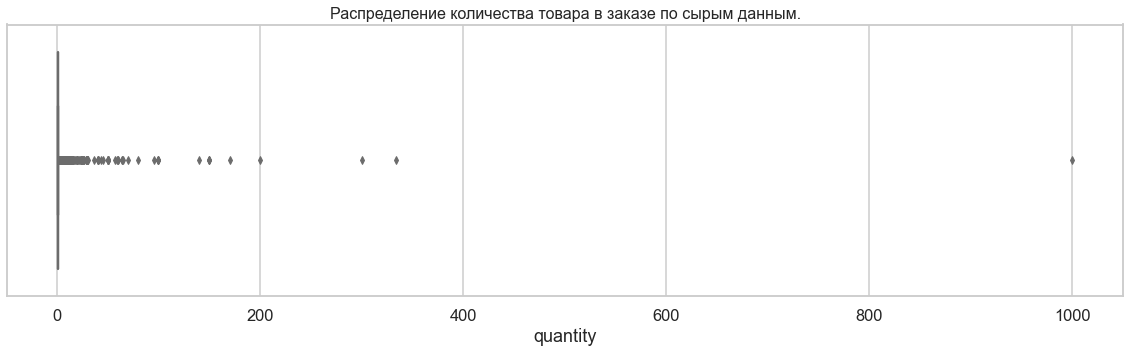

In [13]:
# Удалим выбросы с помощью перцентилей
upper_limit_quantity =df['quantity'].quantile(.99) # граница аномальных значений 
print('99-й перцентиль кол-ва товара в заказе: {:.0f} '.format(upper_limit_quantity))

# количество аномальных значений в столбце 'quantity'
abnormalnumber_q = df[df['quantity'] > upper_limit_quantity]['quantity'].count()
print('Количество строк с аномальными значениями: {} строк'.format(abnormalnumber_q))
print('Доля аномальных значений от общего количества записей: {:.1%}'.format(abnormalnumber_q / len(df))) 

plt.figure(figsize=(20,5))
sns.boxplot(x='quantity', data=df)

plt.title('Распределение количества товара в заказе по сырым данным.', fontsize=16)
plt.show()

Менее 1% транзакций интернет-магазина приходится на проданных 30 товаров. На результат анализа они не повлияют, можно их удалить.

Удалим аномальные значения из датасета 

In [14]:
df = df[(df['quantity'] < upper_limit_quantity)]

Выведем статистику датасета методом describe()

In [15]:
df.describe().T

count     mean      std      min      25%      50%      75%  \
order_id 5530.00 55890.82 32509.11 12624.00 14809.00 69201.50 71937.75   
quantity 5530.00 1.73     2.60     1.00     1.00     1.00     1.00       
price    5530.00 535.96   977.16   9.00     90.00    150.00   537.25     

               max  
order_id 112789.00  
quantity 29.00      
price    14917.00

### Визуализация данных

In [16]:
#Для оценки данных применим метод pandas_profiling 
report = pandas_profiling.ProfileReport(df)
report

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<div class="alert alert-info">  
    
Для каждого столбца массива появилась следующая статистика:
    

- Основная информация: тип, уникальные значения, количество нулевых и пропущенных значений
    
- Квантильная статистика: минимальное и максимальное значения, квартили, интерквартильный размах и др.
    
- Описательная статистика: среднее значение, мода, стандартное отклонение, коэффициенты асимметрии, самые частые значения и др.
    
- Графическая информация: гистограмма, корреляционные матрицы и др.
    
    

</div>

### Добавим необходимые столбцы

In [17]:
# Добавим столбец выручки c заказа
df['revenue'] = df['quantity'] * df['price']

In [18]:
# Выделим в отдельные столбцы время, день, неделю, месяц, год и полную дату
df['hour'] = df.datetime.dt.hour
df['day'] = (df.datetime.dt.dayofweek) + 1 # +1, от понедельника = 1, до воскресенья = 7
df['week'] = df.datetime.dt.week
df['month'] = df.datetime.dt.month
df['year'] = df.datetime.dt.year
df['date'] = df.datetime.dt.date

Создадим отдельный столбец, где будни = 1, выходные = 0  

In [19]:
#Функция, принимающая номер дня и возвращающая будни и выходные
def sensor_weekdays(day):
    if  1 <= day <= 5:
        return 1
    else:
        return 0

def sensor_weekends(day):
    if  6 <= day <= 7:
        return 1
    else:
        return 0

In [20]:
# Cоздадим отдельные столбцы будни/выходные 
df['weekdays'] = df['day'].apply(sensor_weekdays)
df['weekends'] = df['day'].apply(sensor_weekends)
df.sample(10, random_state=123) 

datetime                           customer_id  order_id  \
6578 2019-10-11 09:00:00  39bded4f-7358-4fce-a313-a7cb2d3a7005  72929      
6969 2019-12-02 16:00:00  a4475003-d39f-4d68-a289-8c63d697cde4  109356     
2383 2019-03-18 19:00:00  fb117193-682f-44ab-b9fe-e9be18801e36  14580      
6463 2019-09-28 19:00:00  ab292e24-9fdf-469a-8ea7-aad0112e4593  14938      
2920 2019-04-16 22:00:00  d4f984b6-ea59-4618-a26f-79a053e483c7  14653      
7171 2019-12-29 11:00:00  0fa27f87-2f4e-4a22-acf0-53e5dd02654d  108135     
296  2018-10-17 18:00:00  7059aee2-80ae-4cdf-9d0d-31d41f665dca  68678      
4025 2019-05-24 22:00:00  d8080f8f-3685-433b-b416-beb0a8f06606  71480      
6809 2019-11-08 21:00:00  71129bd1-b3d1-4eb2-966e-ad3591ccf2cb  110353     
805  2018-11-13 15:00:00  65b2fdef-1949-4bd8-a460-6dcb6a4ca896  68991      

                                                                                product  \
6578  сумка-тележка хозяйственная rolser imx004 negro logic rg черная                     
6969  пеларгония розебудная prins nikolai укорененный черенок                             
2383  пеларгония зональная диам. 12 см красный махровый                                   
6463  пеларгония тюльпановидная emma                                                      
2920  роза садовая чайногибридная в горшке керио                                          
7171  контейнер для свч пц2211лм с паровыпускным клапаном 05 л лайм                       
296   герань домашняя пеларгония зональная цветущая d12 h25-30 малиново розовая простая   
4025  мята перечная шоколадная chocolate d-7 см h-10 см укорененный черенок               
6809  вешалка настенная ника вн3 3 крючка медный антик                                    
805   сумка-тележка хозяйственная gimi argo салатовая                                     

      quantity   price  revenue  hour  day  week  month  year        date  \
6578  1        6075.00 6075.00   9     5    41    10     2019  2019-10-11   
6969  1        134.50  134.50    16    1    49    12     2019  2019-12-02   
2383  1        150.00  150.00    19    1    12    3      2019  2019-03-18   
6463  1        135.00  135.00    19    6    39    9      2019  2019-09-28   
2920  1        188.00  188.00    22    2    16    4      2019  2019-04-16   
7171  1        44.00   44.00     11    7    52    12     2019  2019-12-29   
296   1        149.00  149.00    18    3    42    10     2018  2018-10-17   
4025  1        74.00   74.00     22    5    21    5      2019  2019-05-24   
6809  1        134.00  134.00    21    5    45    11     2019  2019-11-08   
805   1        1049.00 1049.00   15    2    46    11     2018  2018-11-13   

      weekdays  weekends  
6578  1         0         
6969  1         0         
2383  1         0         
6463  0         1         
2920  1         0         
7171  0         1         
296   1         0         
4025  1         0         
6809  1         0         
805   1         0

**Вывод**

На этапе знакомства с данными выявлены следующие проблемы - некорректный тип в дате, неодинаковый регистр букв в столбце с наименованием товара, выбросы в количестве и цене товара.


На этапе предобработки данных - привели дату к формату даты, привели наименование товара к нижнему регистру, заменили ё на е. 

Обнаружили неполные дубликаты в столбце с наименованием товара и идентификатором заказа и удалили их. Возможно произошли сбои при выгрузки данных или при записи транзакции.


На этапе обработки выбросов, удалили из датасета аномальные значения в количестве товара с помощью перцентилей. Добавили нужные для исследования столбцы.

## Анализ торгового ассортимента

### Обработаем аномальные значения в датах заказов

In [21]:
# Найдем минимальную и максимальную дату
min_datetime = df['datetime'].min()
max_datetime = df['datetime'].max()

print("Дата первой записи в логе: {} ".format(min_datetime))
print("Дата последней записи в логе: {} ".format(max_datetime))
print("Период ведения лога: {} ".format(max_datetime - min_datetime))

Дата первой записи в логе: 2018-10-01 00:00:00 
Дата последней записи в логе: 2020-01-31 15:00:00 
Период ведения лога: 487 days 15:00:00 


Построим гистограмму по дате и времени

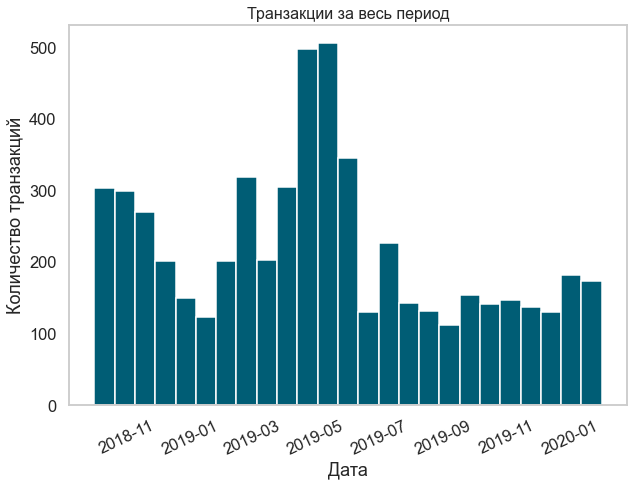

In [22]:
plt.figure(figsize=(10,7)) 
plt.title('Транзакции за весь период', fontsize=16)
df['datetime'].hist(bins=25, grid=False, color='#005d75')
plt.xticks(rotation=25)
plt.xlabel('Дата')
plt.ylabel('Количество транзакций')
plt.show()

Мы располагаем данными с 2018-11-01 по 2020-01-31, это 1 год и 3 месяца. С апреля 2019 года виден рост  количества покупок. Пик приходится на июнь 2019 года. Наблюдаем сезонность в продажах.

In [23]:
# Найдем количество заказов, которые относятся сразу к нескольким датам
order_multiple_dates = df.groupby('order_id').agg({'date':'nunique'})\
                      .sort_values(by='date', ascending=False).query('date > 1')
print('Количество заказов, которые относятся сразу к нескольким датам: {} заказа'.format(len(order_multiple_dates)))

Количество заказов, которые относятся сразу к нескольким датам: 32 заказа


В датасете 32 заказа с несколькими датами на один заказ. Возмжно, это технические ошибки, сбои при оформлении заказа или сохранении данных. 

### Посмотрим аномалии в заказах

In [24]:
# Посчитаем общее число покупателей
customers_total = len(df['customer_id'].unique())
print("Всего покупателей за весь период: {} человек".format(customers_total))

Всего покупателей за весь период: 2404 человек


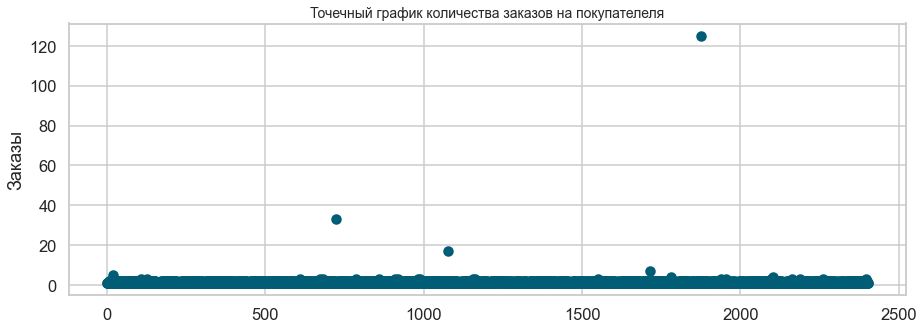

customer_id  orders
1876  c971fb21-d54c-4134-938f-16b62ee86d3b  125   
724   4d93d3f6-8b24-403b-a74b-f5173e40d7db  33    
1075  73d1cd35-5e5f-4629-8cf2-3fda829d4e58  17    
1714  b7b865ab-0735-407f-8d0c-31f74d2806cc  7     
17    0184f535-b60a-4914-a982-231e3f615206  5     
...                                    ... ..     
977   6a2c26b2-49f5-4298-bd38-2e0a2a50fc0c  1     
976   6a2bdd04-7d99-4f78-8bce-e7b37bb7abbb  1     
973   69cf691b-a6c2-4543-aa8a-8cf42fe4a76e  1     
972   69c524f1-dd2a-4c4e-a5b0-def54dc96f9e  1     
2403  ffe82299-3f5b-4214-87fe-3d36ecccfac3  1     

[2404 rows x 2 columns]

In [25]:
# Подсчитаем количество заказов по покупателелям  
orders_per_customer = df.groupby('customer_id', as_index=False).agg({'order_id':'nunique'})
orders_per_customer.columns = ['customer_id','orders']

# Построим точечный график количества заказов 
x_values = pd.Series(range(0,len(orders_per_customer)))

sns.set_style('whitegrid')
plt.figure(figsize=(15,5))
plt.scatter(x_values, orders_per_customer['orders'], color='#005d75')   
plt.ylabel('Заказы')
plt.title('Точечный график количества заказов на покупателеля', fontsize=14)
plt.show()
orders_per_customer.sort_values(by='orders',ascending=False)

Большинство покупателей сделали всего 1 заказ. Клиентов с 3 заказами совсем мало. Также есть пользователи с 5, 7, 17, 33 и 125 заказов, что выглядит как аномалия.

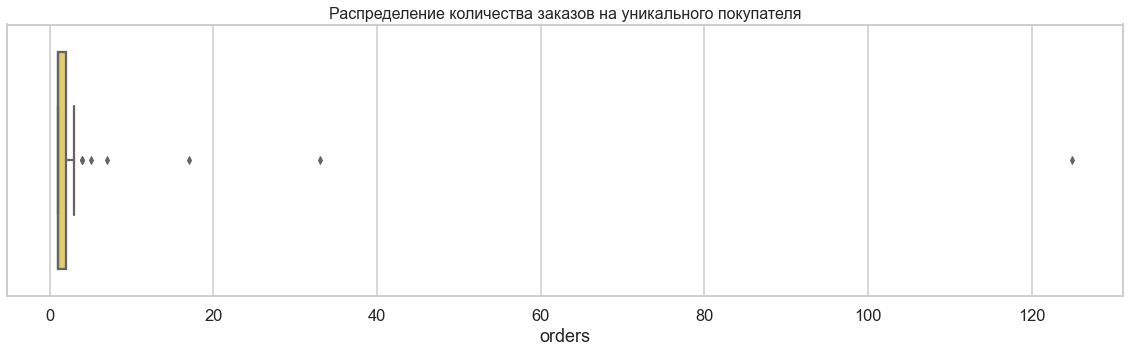

In [26]:
# Построим боксплот распределения заказов для каждого уникального покупателя
plt.figure(figsize=(20,5))
sns.boxplot(x='orders', data=orders_per_customer, color='#F2D95D')
plt.title('Распределение количества заказов на уникального покупателя', fontsize=16)
plt.show()

In [27]:
# Посчитаем 95-й и 99-й перцентили количества заказов по покупателелям  
percentiles = np.percentile(orders_per_customer['orders'], [95, 99])
print('95-й перцентиль количества заказов на покупателя: {} заказа'.format(percentiles[0]))
print('99-й перцентиль количества заказов на покупателя: {} заказа'.format(percentiles[1]))

95-й перцентиль количества заказов на покупателя: 2.0 заказа
99-й перцентиль количества заказов на покупателя: 3.0 заказа


Не более 5% клиентов сделали больше 2 заказов, не более 1% клиентов – больше 3 заказов.  

### Посмотрим на активность покупателей и построим графики изменения метрик во времени

Активных покупателей оценивают в трёх измерениях:

- DAU — количество уникальных покупателей в день;

- WAU — количество уникальных покупателей в неделю;

- MAU — количество уникальных покупателей в месяц.

Посчитаем метрики. Сгруппируем данные по уникальным покупателям и найдём среднее значение. Затем построим графики по изменению метрик во времени.

In [28]:
dau = df.groupby('date').agg({'customer_id': 'nunique'}).mean()
wau = df.groupby(['year', 'week']).agg({'customer_id': 'nunique'}).mean()
mau = df.groupby(['year', 'month']).agg({'customer_id': 'nunique'}).mean()

print('Среднее количество уникальных покупателей в день: {} человек'.format(int(dau)))
print('Среднее количество уникальных покупателей в неделю: {} человек'.format(int(wau)))
print('Среднее количество уникальных покупателей в месяц: {} человек'.format(int(mau)))

Среднее количество уникальных покупателей в день: 6 человек
Среднее количество уникальных покупателей в неделю: 46 человек
Среднее количество уникальных покупателей в месяц: 199 человек


In [29]:
# Посчитаем регулярность пользования интернет-магазином
sticky_wau = (dau / wau) * 100
sticky_mau = (dau / mau) * 100
print('Недельная аудитория: {}'.format(sticky_wau[0]))
print('Месячная аудитория: {}'.format(sticky_mau[0]))

Недельная аудитория: 14.939371608494675
Месячная аудитория: 3.47794894589294


Показатели низкие, а значит в интернет-магазине покупают нечасто.

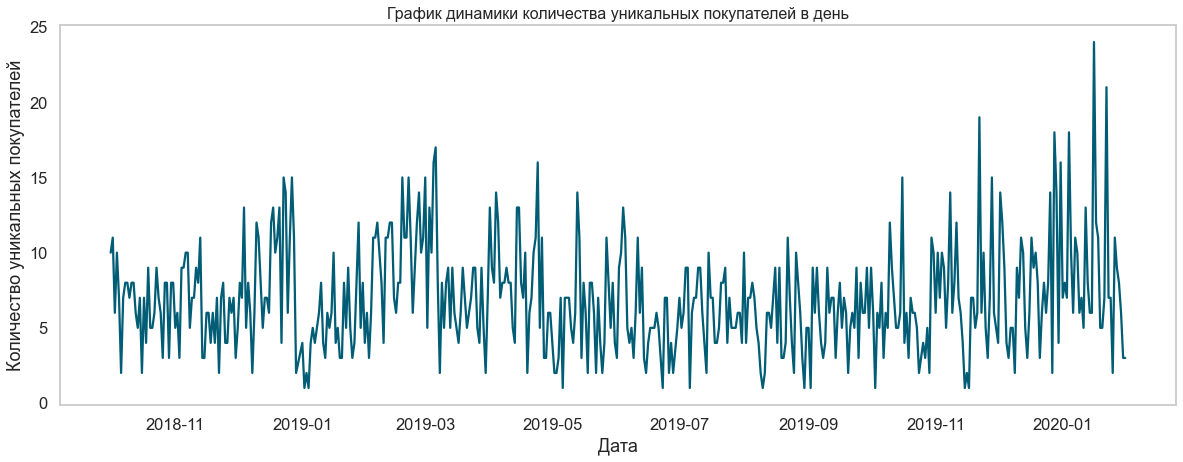

In [30]:
# График динамики DAW 
df.groupby(['date']).agg({'customer_id': 'nunique'}) \
         .plot(figsize=(20,7), grid=False, legend=False, color='#005d75')
plt.title('График динамики количества уникальных покупателей в день', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Количество уникальных покупателей')
plt.show()

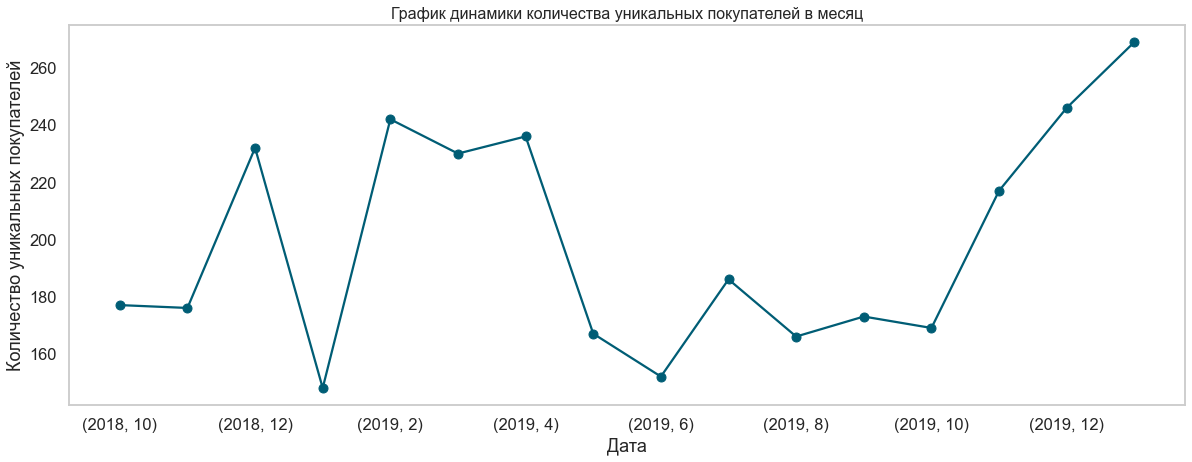

In [31]:
# График динамики MAU  
df.groupby(['year', 'month']).agg({'customer_id': 'nunique'}) \
      .plot(marker='o', figsize=(20,7), grid=False, legend=False, color='#005d75')
plt.title('График динамики количества уникальных покупателей в месяц', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Количество уникальных покупателей')
plt.show()

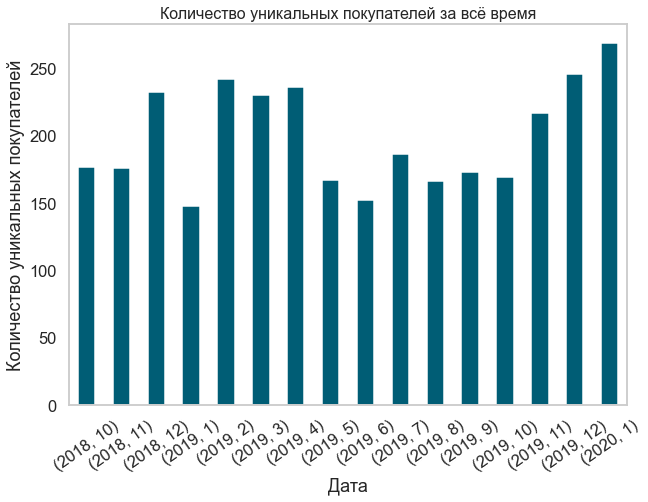

In [32]:
#График количества уникальных покупателй за всё время
customers_per_month = df.pivot_table(index=['year','month'],values='customer_id',aggfunc='nunique')
                               
customers_per_month.columns = ['customers']
customers_per_month.plot(kind='bar', figsize=(10,7), grid=False, y=['customers'],\
                         rot=35, color='#005d75', legend=False)

plt.title('Количество уникальных покупателей за всё время', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Количество уникальных покупателей')
plt.show()

**Выводы**

По очищенным данным:

- Всего покупателей - 2404 человек.
- Большинство покупателей совершило всего 1 заказ.
- Покупателей заказавших 3 заказа мало.
- Среднее количество уникальных покупателей в день - 6 человек.
- Среднее количество уникальных покупателей в неделю - 46 человек.
- Среднее количество уникальных покупателей в месяц - 199 человек.
- Недельная аудитория - 14.9%
- Месячная аудитория - 3.4%

За месяц интернет-магазин в среднеем имеет 199 клиентов. Это небольшая цифра. Видно, что покупают нечасто.

На графиках в феврале-марте 2019 виден рост активности покупателей. Затем падение активности с апреля до июля 2019 года. С июля снова 2019 видим небольшой рост. Продаж больше всего в конце и начале года, а также на праздники 23.02. и 08.03.

#### Посчитаем количество заказов и построим графики изменений во времени

In [33]:
# Посчитаем общее количество заказов
orders_total = len(df['order_id'].unique())
print("Всего заказов за весь период: {} ".format(orders_total))

Всего заказов за весь период: 3471 


В таблице 2404 уникальных покупателей совершивших 3471 заказа за 487 дней.

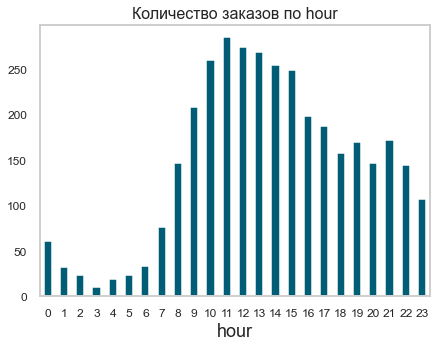

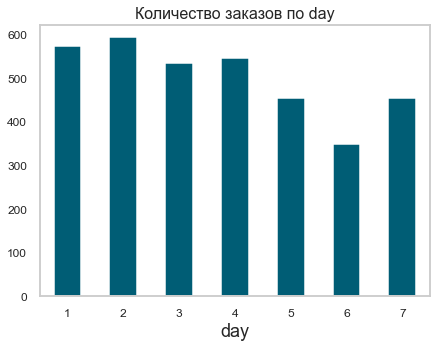

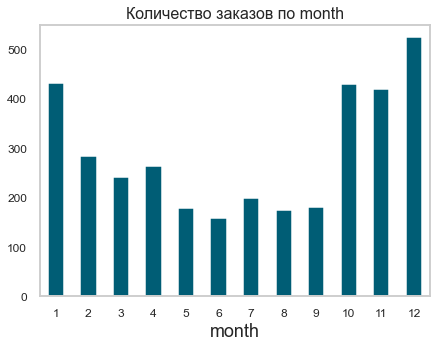

In [34]:
# Цикл построения графиков по часам, по дням и месяцам 
for columns in ['hour', 'day', 'month']:
    df.pivot_table(index=columns, values='order_id', aggfunc='nunique', fill_value=0)\
    .plot(kind='bar', figsize=(7,5), grid=False, y=['order_id'], color='#005d75', fontsize=12, legend=False)
    plt.title('Количество заказов по ' + columns, fontsize=16)
    plt.xticks(rotation=0)
    plt.show()

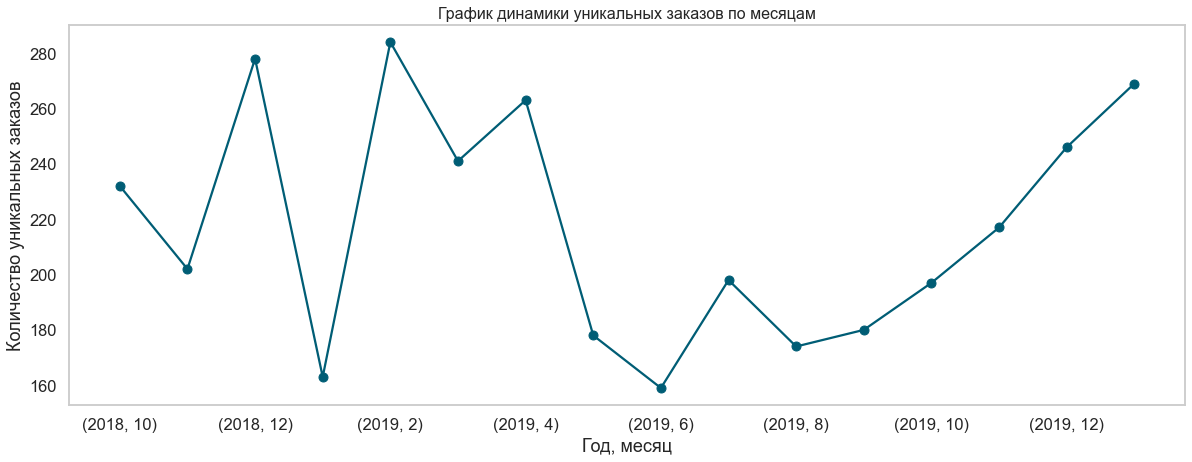

In [35]:
# График месячной динамики заказов во времени
df.groupby(['year', 'month']).agg({'order_id': 'nunique'}) \
      .plot(marker='o', figsize=(20,7), grid=False, legend=False, color='#005d75')
plt.title('График динамики уникальных заказов по месяцам', fontsize=16)
plt.xlabel('Год, месяц')
plt.ylabel('Количество уникальных заказов')
plt.show()

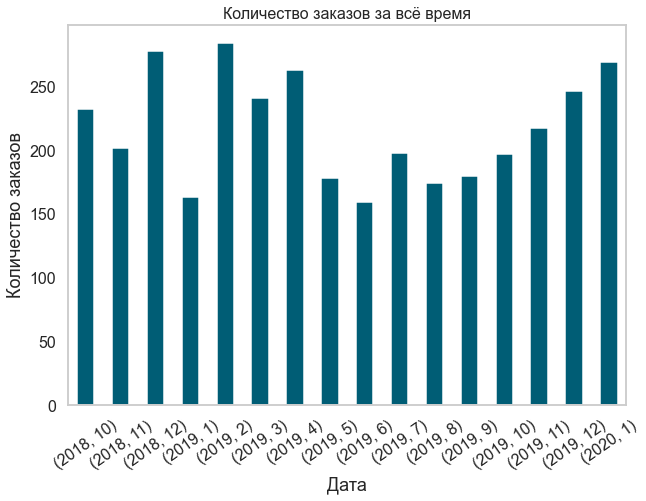

In [36]:
# График количества заказов за весь период
orders_per_month = df.pivot_table(index=['year','month'],values='order_id',aggfunc='nunique')
                               
orders_per_month.columns = ['orders']
orders_per_month.sort_values(by='orders', ascending=False)

orders_per_month.plot(kind='bar', y=['orders'], figsize=(10,7), grid=False,\
                      rot=35, fontsize=16, color='#005d75', legend=False)
plt.title('Количество заказов за всё время', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

**Вывод**

В таблице 2404 уникальных покупателей совершивших 3471 заказ за 487 дней.
Большинство заказов совершаются в первой половине дня с 9 до 15. Пик приходится на 11 часов. Меньше всего клиенты заказываю ночью.

С воскресенья виден рост заказов. Пик приходится на вторник, с наибольшим количеством покупок. Затем снижение, и меньше всего продаж в субботу.

В апреле и феврале 2019, а также январе 2020 сделано больше всего заказов. Это коррелирует с активностью клиентов. То есть, количество сделавших заказ зависит от активности покупателей.

#### Оценим сумму выручки, и как она изменяется во времени

In [37]:
# Сумма выручки
revenue_sum = df['revenue'].sum()
print('Сумма выручки: {:.2f} eд.'.format(revenue_sum))

Сумма выручки: 3672746.42 eд.


In [38]:
# Cредняя выручка с покупателя.
revenue_mean = df['revenue'].mean()
print('Cредняя выручка с покупателя: {:.2f} eд.'.format(revenue_mean))

Cредняя выручка с покупателя: 664.15 eд.


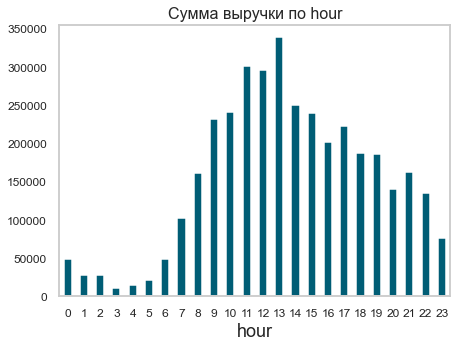

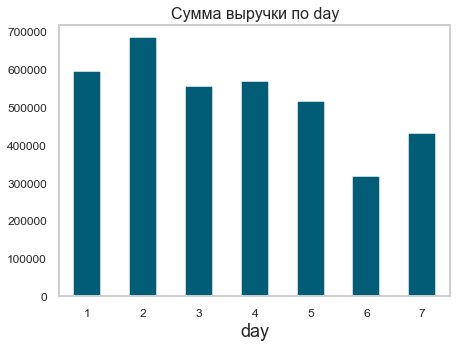

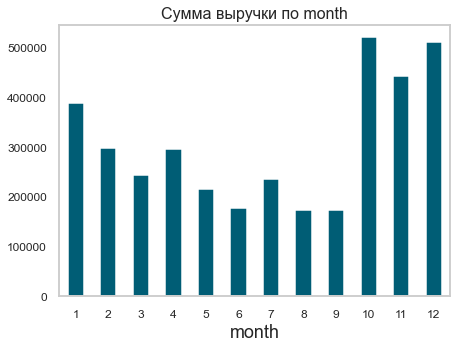

In [39]:
# Цикл для построения графиков
for columns in ['hour', 'day', 'month']:
    df.pivot_table(index=columns, values='revenue', aggfunc='sum', fill_value=0)\
    .plot(kind='bar', figsize=(7,5), grid=False, y=['revenue'], color='#005d75', fontsize=12, legend=False)
    plt.title('Сумма выручки по ' + columns, fontsize=16)
    plt.xticks(rotation=0)
    plt.show()

revenue  avg_revenue
year month                       
2018 10    325002.00 684.21      
     11    313170.00 736.87      
     12    308058.00 993.74      
2019 2     298276.00 835.51      
     4     296545.00 440.63      
     3     244222.00 597.12      
     7     234932.00 752.99      
     5     215745.00 295.95      
     1     213622.00 1180.23     
     12    202885.33 824.74      
     10    194838.00 910.46      
     6     177258.00 607.05      
2020 1     174036.33 646.98      
2019 9     172922.00 789.60      
     8     172443.00 853.68      
     11    128791.75 593.51

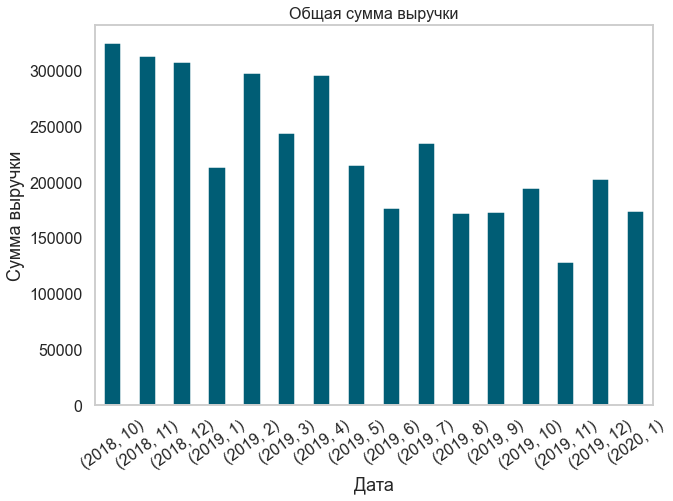

In [40]:
# Посчитаем сумму выручки за весь период
revenue_per_month = df.pivot_table(index=['year','month'],values='revenue',aggfunc=['sum', 'mean'])
revenue_per_month.columns = ['revenue', 'avg_revenue']
display(revenue_per_month.sort_values(by='revenue', ascending=False))

revenue_per_month.plot(kind='bar', y=['revenue'], figsize=(10,7), grid=False, color='#005d75',\
                       rot=35, fontsize=16, legend=False)
plt.title('Общая сумма выручки', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Cумма выручки')
plt.show()

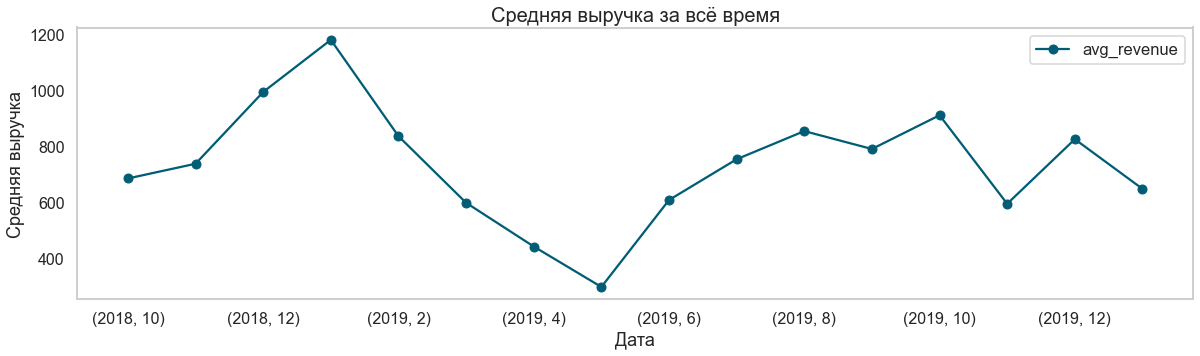

In [41]:
# Посчитаем среднюю выручку за весь период
avg_revenue_per_month = df.pivot_table(index=['year','month'],values='revenue',aggfunc='mean')
avg_revenue_per_month.columns = ['avg_revenue']
avg_revenue_per_month.sort_values(by='avg_revenue', ascending=False)

avg_revenue_per_month.plot(marker='o', y=['avg_revenue'], figsize=(20,5), grid=False, color='#005d75', fontsize=16)
plt.title('Средняя выручка за всё время', fontsize=20)
plt.xlabel('Дата')
plt.ylabel('Средняя выручка')
plt.show()

year  month   revenue  customers  orders  revenue_per_customer  \
1   2018  11    313170.00  176        202    1779.38                 
0   2018  10    325002.00  177        232    1836.17                 
3   2019  1     213622.00  148        163    1443.39                 
7   2019  5     215745.00  167        178    1291.89                 
9   2019  7     234932.00  186        198    1263.08                 
6   2019  4     296545.00  236        263    1256.55                 
8   2019  6     177258.00  152        159    1166.17                 
2   2018  12    308058.00  232        278    1327.84                 
4   2019  2     298276.00  242        284    1232.55                 
5   2019  3     244222.00  230        241    1061.83                 
10  2019  8     172443.00  166        174    1038.81                 
12  2019  10    194838.00  169        197    1152.89                 
11  2019  9     172922.00  173        180    999.55                  
14  2019  12    202885.33  246        246    824.74                  
15  2020  1     174036.33  269        269    646.98                  
13  2019  11    128791.75  217        217    593.51                  

    revenue_per_order  
1  1550.35             
0  1400.87             
3  1310.56             
7  1212.05             
9  1186.53             
6  1127.55             
8  1114.83             
2  1108.12             
4  1050.27             
5  1013.37             
10 991.05              
12 989.03              
11 960.68              
14 824.74              
15 646.98              
13 593.51

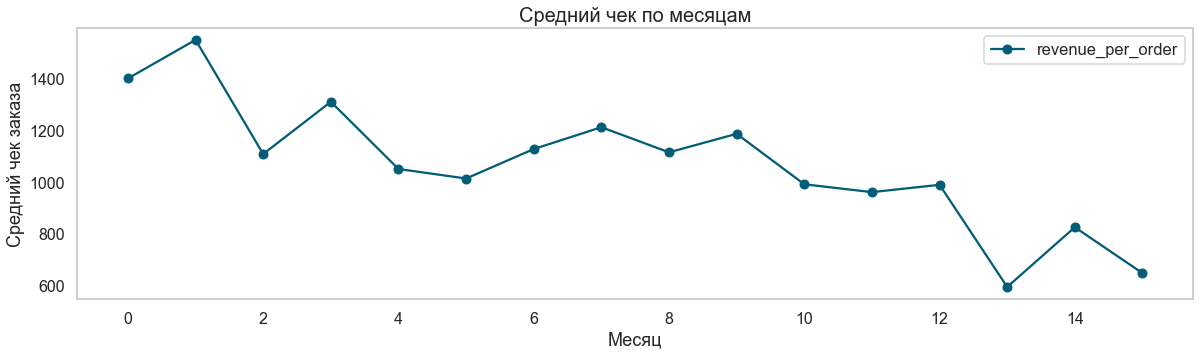

In [42]:
# Найдём средний чек покупателя  
avg_check = df.groupby(['year','month']) \
                                    .agg({'revenue':'sum','customer_id':'nunique', 'order_id':'nunique'}).reset_index()
avg_check.columns = ['year', 'month', 'revenue', 'customers', 'orders']   
avg_check['revenue_per_customer'] = avg_check['revenue'] / avg_check['customers']

# Найдём средний чек заказов  
avg_check['revenue_per_order'] = avg_check['revenue'] / avg_check['orders']
display(avg_check.sort_values(by='revenue_per_order',ascending=False))


avg_check.plot(marker='o', y=['revenue_per_order'], figsize=(20,5), grid=False, color='#005d75', fontsize=16)
plt.title('Средний чек по месяцам', fontsize=20)
plt.xlabel('Месяц')
plt.ylabel('Средний чек заказа')
plt.show()

**Выводы**

Общая сумма выручки - 3 672 746.42 eд. 

Cредняя выручка с покупателя - 664.15 eд.


День недели вторник в 13:00 дня самый продуктивный, приносит больше всего выручки.
В течение всего периода 2018-2020 наблюдается негативная динамика суммарной выручки от продаж. 

Общая сумма выручки в конце 2019 года сократилась почти в 1,5 раза, относительно прошлого года.   Причиной могло послужить общее ухудшение экономической ситуации, сокращение рынка.

Снижение доходов с продаж также видно по среднему чеку покупателя. В октябре 2018 года средний чек покупателя был 1377.92, а через год, в октябре 2019 года - 962.81 ед.

### Найдём товары, которые дают наибольшую выручку

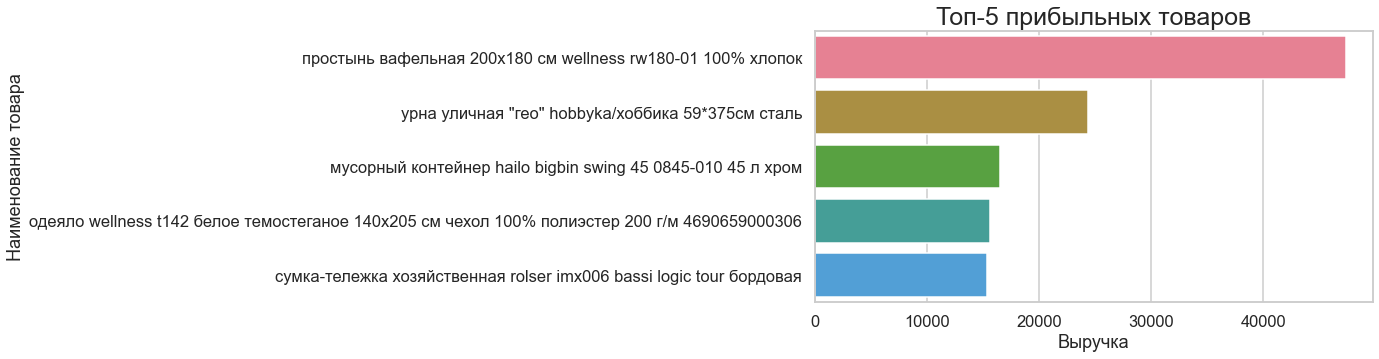

In [43]:
# Посмотрим, какие товары приносят наибольшую прибыль
most_profit_products = df.pivot_table(index=['order_id','product'], values='revenue', aggfunc='sum')\
                               .sort_values(by='revenue', ascending=False).reset_index()
most_profit_products.head()
plt.figure(figsize=(10,5))
plt.title('Топ-5 прибыльных товаров', fontsize=25) #alpha=.80
sns.barplot(x='revenue', y='product', data=most_profit_products[:5]).set(xlabel='Выручка', 
                                                                         ylabel='Наименование товара')
plt.show()

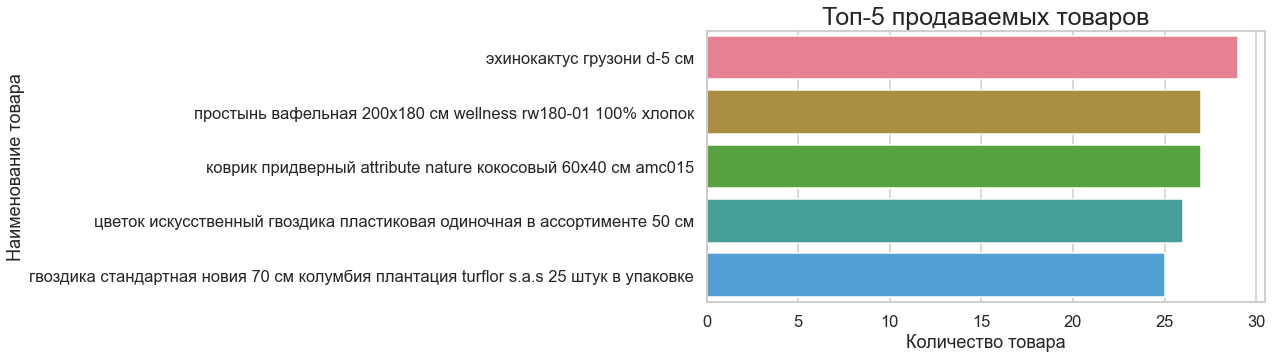

In [44]:
# Самые продаваемые товары за всё время   
all_time_best_sellers = df.pivot_table(index=['order_id','product'],\
                                                   values='quantity',\
                                                   aggfunc='sum').sort_values(by='quantity',ascending=False).reset_index()


plt.figure(figsize=(10,5))
plt.title('Топ-5 продаваемых товаров', fontsize=25) 
sns.barplot(x='quantity',y='product',data=all_time_best_sellers[:5]).set(xlabel='Количество товара', 
                                                                         ylabel='Наименование товара')
plt.show()

In [45]:
all_time_best_sellers.head()

order_id  \
0  70327      
1  69830      
2  68908      
3  71351      
4  70976      

                                                                                product  \
0  эхинокактус грузони d-5 см                                                             
1  простынь вафельная 200х180 см wellness rw180-01 100% хлопок                            
2  коврик придверный attribute nature кокосовый 60x40 см amc015                           
3  цветок искусственный гвоздика пластиковая одиночная в ассортименте 50 см               
4  гвоздика стандартная новия 70 см колумбия плантация turflor s.a.s 25 штук в упаковке   

   quantity  
0  29        
1  27        
2  27        
3  26        
4  25

**Выводы**

Топ-5 самых прибыльных товара за весь период:

- простынь вафельная 200х180 см wellness
- урна уличная "гео" hobbyka/хоббика
- мусорный контейнер hailo bigbin swing 45
- одеяло wellness t142 белое темостеганое 140х205 см
- сушилка уличная leifheit 85210 linomatic

Топ-5 самых продаваемых товаров за весь период:

- эхинокактус грузони d-5 см
- коврик придверный attribute nature кокосовый 60x40 см amc015
- простынь вафельная 200х180 см wellness rw180-01 100% хлопок
- цветок искусственный гвоздика пластиковая одиночная в ассортименте 50 см
- муляж яблоко зеленый 9 см полиуретан

### Построим матрицу корреляции

In [46]:
# Удалим столбец order_id, он не должен попасть в расчет корреляции
df_corr = df.drop(df.columns[2], axis = 1)

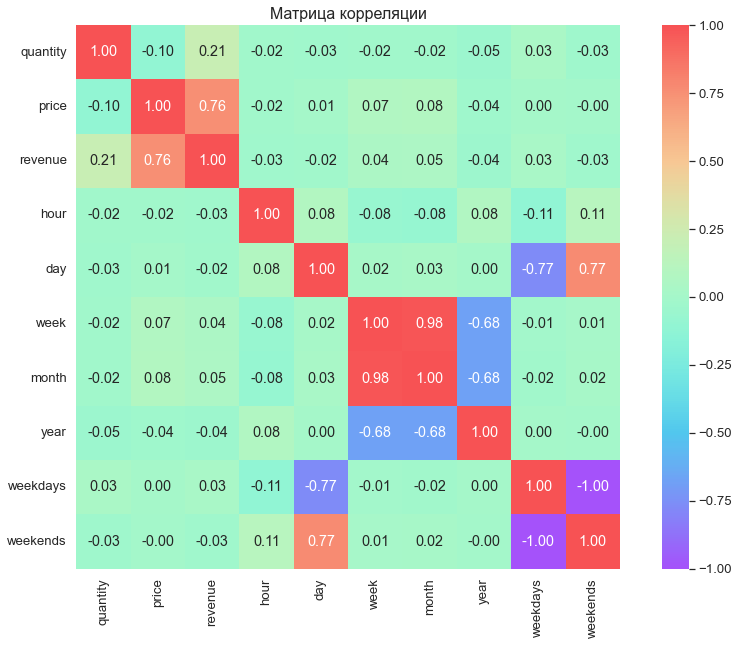

In [47]:
plt.figure(figsize=(15,10))
sns.set(font_scale=1.2)
sns.heatmap(data=df_corr.corr(), annot=True, square=True, alpha=.65, fmt='.2f', cmap='rainbow') 
plt.title('Матрица корреляции', fontsize=16)
plt.show()

**Вывод**

Наблюдаем корреляцию переменных. Есть небольшая взаимозависимость выручки с ценой товара corr = 0,76, то есть чем выше цена товара, тем больше выручка. Также, положительно коррелируют с выручкой количество заказов и товара.

## Распределение товара по категориям 

### Лемматизация

In [48]:
# Посмотрим уникальные значения столбца 'product' 
unique_product = df['product'].unique() 

# Выделим леммы в значениях столбца с наименованием товара для создания словаря
m = Mystem()
string = '; '.join(unique_product)  
lemmas = m.lemmatize(string) 
#print(Counter(lemmas))

Counter({' ': 16635, '; ': 2319, 'см': 1055, '-': 971, 'для': 540, 'в': 274, 'd': 259, 'л': 252, 'с': 249, 'рассада': 221, 'сорт': 171, 'кассета': 170, 'белый': 170, 'шт': 168, 'красный': 143, 'белье': 142, '12': 140, 'доска': 132, '/': 131, 'горшок': 130, '9': 119, 'сушилка': 118, 'цветок': 118, 'объем': 114, 'гладильный': 113, 'тележка': 108, '6': 102, 'по': 101, 'томат': 100, 'сумка': 98, '. ': 98, '10': 97, 'диам': 95, 'помидор': 93, '*': 89, '№': 88, '4': 87, 'пеларгония': 86, '2': 84, 'розовый': 84, 'из': 82, '05': 82, 'и': 80, 'хозяйственный': 77, 'luminarc': 76, 'ника': 75, 'gimi': 74, 'среднеспелый': 73, 'коврик': 72, 'ванный': 72, 'кухня': 71, '3': 70, '20': 69, 'зелень': 68, '1': 68, 'роза': 68, 'муляж': 67, 'черный': 67, 'мл': 67, '7': 65, 'синий': 63, '100': 62, 'махровый': 62, 'г': 61, 'зональный': 61, 'h': 60, 'чехол': 60, 'м': 60, 'искусственный': 60, 'пластмассовый': 59, 'attribute': 58, 'однолетний': 57, 'пластиковый': 54, 'штора': 54, 'штука': 54, 'комната': 53, '% '

**Вывод**

Из лемм в значениях столбца 'product', выделим 10 категорий:

- хранение
- мебель
- кухня
- ванная
- текстиль
- сад
- уборка
- инструменты
- гигиена
- декор

### Распределим товар по категориям

Для составления словаря возьмём список с уникальным наименованием товара unique_product и посчитанным количеством упоминаний Counter

In [49]:
# Cоздадим словарь категорий по спискам слов из лемм и уникальных наименований товаров

category_dictionary = {
    'хранение':['бак','вакуумный','весы','петля','вешалка','вешалки','вкладыши','корзина','короб','коробка','кофр', 
                'крючок','обувная','лоток','мусора','монетчатый','мусорный','набор вешалок','котовник','петля', 
                'сумка','тележ','плечики','полки','решетка','складная','стеллаж','сумка','тележка',
                'хозяйственная','урна','этажерка','ящик'],
    
    'мебель': ['подставка','стеллаж','комод','карниз','этажерка','пуф','обувниц','светиль','фото',
               'для обув','комод','защитный','обувница','обуви','светильник'],
    
    'кухня':['банка','бидон','блюдо','блюдце','ваза','вилка','разделочная','емкость','жестяная','измельчитель',
             'картофелемялка','кастрюля','кипятильник','кисточка','хлебница','интерьерный','кружка',
             'крышка', 'кувшин', 'кухонное','кухонные','столовая','чайная','холодца','мантоварка',
             'пароварка','масленка','мерный','стакан','миксер','мини-сковорода','мирт','миска','модульная', 
             'набор бокалов','набор для пикника','набор ножей','webber','набор стаканов','набор столовых приборов',
             'набор фужеров','фужер','стакан','салатник','нож','ножеточка','овощеварка','овощечистка',
             'просеиватель','противень','разделочная','салатник','салфетка','сковорода',
             'скребок','соковарка','соковыжималка','стакан','стеклянная','тepмокружка','тарелка', 'терка',
             'термокружка','толкушка','фал','форма','хлебница','ложка','чайная','чайник','электроштопор','сито', 
             'подставка для яйца'],
    
    'ванная':['ванна','вантуз','ведро','держатель','дозатор','ерш','запасная','ванной','коврик','ванной', 
              'ковш','мыльница','ванн','подголовник','пробка','унитаза'],
    
    'текстиль':['скатерть','двуспальное','постельное','белье', 'ковер', 'кольца', 'штор', 'полотенце','штора', 
                'ковер', 'махровое','халат','набор ковров', 'наволочка', 'наматрасник', 'одеяло', 'плед', 
                'подкладка', 'чехол','полотенце','простыня','скатерть','халат','чехол','штора',
                'простынь вафельная 200х180 см wellness', 'наматрацник natures бархатный', 'покрывало жаккард шенилл birhome',
                'покрывало жаккард шенилл'],
    
    'cад':['а патио','адиантум','азалия','аквилегия','алиссум','амариллис','альбука','андесса','антижир',
           'арбуз','артемизия','аспарагус','астра','ахарница','бадан','базилик','бак','баклажан',
           'бакопа','бальза','барвинок','бархатцы','бегония','буддлея', 'бузульник', 'валериана', 'вербена',
           'виола', 'газания', 'гвоздика','гардения', 'георгина', 'герань', 'гербера', 'гимнокалициум', 'гиностемма',
           'гипсофила','годеция','горох','гортензия', 'декабрист', 'декоративная','дендробиум', 
           'джункус', 'томата', 'диффенбахия','дыня', 'ель', 'чабер', 'замиокулькас', 'зверобой', 'земляника', 
           'змееголовник', 'импатиенс','иссоп','сантолина', 'кабачок', 'каланхое', 'календула', 'калибрахоа', 
           'калла', 'калоцефалус', 'камнеломка','кампанула', 'капуста', 'кипарисовик', 'клен', 'клубника',
           'колокольчик', 'растение', 'кориандр','космея', 'крассула', 'крокусы','лаванда', 'мята', 'лантана', 
           'лапчатка','лен', 'литопс', 'порей', 'львиный', 'зев','любисток','мединилла','мелисса','многолетнее', 'молодило',
           'петрушка','морковь', 'мята', 'настурция','незабудка','нолина', 'огурец', 'растение','однолетнее', 'осина',
           'орехоколка','патиссон','пахира', 'пеларгония', 'пеларгония', 'петрушка', 'петуни', 'подвесное',
           'цветов','портулак', 'примула', 'пуансеттия','радермахера', 'роза','розмарин','рудбекия','скиммия', 
           'спатифиллум','суккулент','сциндапсус', 'тимьян','томат', 'томата', 'тортница', 'тюльпан', 'рассада', 
           'ранункулус','тыква', 'фаленопсис','фиалка', 'фикус', 'фиттония', 'флокс', 'фуксия', 'хризантема', 
           'целозия', 'цикламен', 'шалфей','эвкалипт','эпипремнум', 'эхеверия', 'эшшольция', 'ясколка', 'шеффлера',
           'хризолидокарпус', 'циперус', 'юкка нитчатая', 'рассада зелени для кухни', 'нефролепис', 'овсянница сизая серый',
           'хлорофитум'],
    
    'уборка':['ароматизиро', 'белье', 'прищепки','веник','гипоаллергенный','гель','гладильная','набор vileda', 
              'набор прищепок','доска','губка','гладильная','защитная','соль','кондиционер','контейнер','стирки', 
              'насадка', 'насадка','швабры','мытья','швабре','сушилка','настенная','настурция','ведра', 
              'пена','перчатки','тряп','швабр','совок','гладил','глажен','прищеп','налет','антижир','пылесос','крем', 
              'стир', 'щетка','сушилк','веник','подрукавник','совком', 'для чистки','стирки','мыть', 'средство',
              'мойк', 'утюг', 'покрытие','гладильной', 'пылесос','гладильной','совок','щетка','средство', 
              'таз','тряпка','корзина','швабра','щетка','средство', 'таз', 'корыто', 'паста для полировки', 
              'вантуз', 'швабр','губка','веник','сменный','дозатор', 'насадка', 'сметка', 'скребок', 'окномойка',
              'совок','чистящий','чистки','антижир','ведр','ерш','тряпка','отбеливатель','для стирки','стиральный',
              'сушилка для белья', 'настенная сушилка для', 'чехол для гладильной доски', 'сушилка для белья',
              'ароматизированное средство дудаления', 'чехол для гладильной доски', 'сушилка для белья', 'attribute', 'gimi',
              'сушилка для белья потолочная лиана люкс', 'сушилка для белья потолочная лиана люкс', 
              'сушилка для белья потолочная zalger lift basic', 'linomatic', 'сушилка уличная', 'leifheit', 
              'сушилка уличная leifheit 85210 linomatic v 400 40 м 175х237х237'],

    
    'инструменты':['инструмент','сверел','сверло','напильник','стремянк','стяжк','шпингалет','сварка',
                   'миксер','крепеж','пружин','петл','линейк','гои','бензин','завертка','крепеж','лестница',
                   'линейка','лопатка','шнур','строительного','многофункциональный','набор прецизионных','полировки',
                   'пьезозажигалка', 'ручка','сверло','седум','сетка','сметка','стремянка','стяжка','термометр',
                   'уголок','фарфоровая','сварка','шило','шнур','шпагат','штангенциркуль', 'чехол eurogold reflector' ],
    
    'гигиена':['зубная','мыло','жидкое','мыло-скраб','увлажняющая','маска','фен'],
    'декор':['искусственная', 'искусственный', 'декоративная', 'котовник', 'муляж', 'новогоднее', 'подарочный',
            'фоторамка', 'комнатное растение в горшке', 'муляж баклажан' ],
}


In [50]:
# Функция, которая вернет категорию по значению ‘product’
def categorize_product(product):
     
    for category, items_of_list in category_dictionary.items():
        for item in items_of_list:
            if item in product:
                return category
    return category

In [51]:
#Cоздадим отдельный столбец с категориями по наименованию товара и значениями из функции
df['category'] = df['product'].apply(categorize_product)
df.shape

(5530, 16)

In [52]:
df.sample(5)

datetime                           customer_id  order_id  \
1015 2018-11-29 10:00:00  b3ef8c7f-a9c5-4567-888a-6807395128d2  69147      
6272 2019-09-06 15:00:00  e8204583-4d55-4724-ad3f-049c7db43bdd  72534      
6761 2019-11-03 17:00:00  74a644e5-0be7-4dce-9136-c4d04a3ee35b  110320     
19   2018-10-01 21:00:00  b731df05-98fa-4610-8496-716ec530a02c  68474      
3791 2019-05-14 19:00:00  bea7a833-2074-42db-bc49-4457abd3c930  14776      
6377 2019-09-21 21:00:00  6718a7fc-75c2-4b8a-820d-b2960be23ca7  14932      
6451 2019-09-28 14:00:00  f55afa87-4427-498e-9015-a6c5a76e4976  14937      
1053 2018-12-02 14:00:00  f4a9fe23-86c5-4690-ae70-a4b7a286a511  69173      
2793 2019-04-11 09:00:00  37af149d-7e2a-4fe8-8fdb-a3a303e24875  14634      
6351 2019-09-18 10:00:00  05257dd3-0c7e-4b4c-a86d-786558162d11  72681      

                                                                          product  \
1015  таз пластмассовый 45 л пищевой "космея" ангора 1404092                        
6272  мединилла магнифика d-17 см h-60 см                                           
6761  хризолидокарпус лутесценс d-9 см                                              
19    доска гладильная eurogold professional 130х48 см металлическая сетка 35748w   
3791  пеларгония зональная махровая лососевая                                       
6377  базилик смесь зеленого и фиолетового 04 г 4660010775433                       
6451  пеларгония зональная диам. 12 см сиреневый полумахровый                       
1053  сушилка для белья потолочная лиана 18 м 1703007                               
2793  пеларгония розебудная mary укорененный черенок                                
6351  гортензия микс в кашпо с автополивом                                          

      quantity   price  revenue  hour  day  week  month  year        date  \
1015  20       62.00   1240.00   10    4    48    11     2018  2018-11-29   
6272  1        1034.00 1034.00   15    5    36    9      2019  2019-09-06   
6761  1        179.00  179.00    17    7    44    11     2019  2019-11-03   
19    1        3299.00 3299.00   21    1    40    10     2018  2018-10-01   
3791  7        161.00  1127.00   19    2    20    5      2019  2019-05-14   
6377  1        11.00   11.00     21    6    38    9      2019  2019-09-21   
6451  1        150.00  150.00    14    6    39    9      2019  2019-09-28   
1053  1        577.00  577.00    14    7    48    12     2018  2018-12-02   
2793  3        135.00  405.00    9     4    15    4      2019  2019-04-11   
6351  1        3599.00 3599.00   10    3    38    9      2019  2019-09-18   

      weekdays  weekends category  
1015  1         0         cад      
6272  1         0         cад      
6761  0         1         cад      
19    1         0         уборка   
3791  1         0         cад      
6377  0         1         cад      
6451  0         1         cад      
1053  0         1         cад      
2793  1         0         cад      
6351  1         0         cад

### АВС-анализ для определения основного и дополнительного ассортимента

ABC-анализ выделяет товары, которые приносят основной доход:

1.  Определим процент от выручки, который приносит каждая позиция
2.  Распределим все товары по убыванию этого процента
3.  Рассчитаем по каждой строке долю выручки нарастающим итогом, начиная с тех товаров, которые дают самый существенный вклад.

#### АВС-анализ по наименованиям товаров

In [53]:
# Группировка данных по товарам и подсчет количества  
abc_prod = df.groupby('product').agg(products=('product', 'count')).reset_index()
abc_prod.columns = ['product', 'count']

# Расчет отношения продуктов в каждой категории к общему числу продуктов
abc_prod['ratio'] = ((abc_prod['count'] / len(df)) * 100).round(1).astype('str') + '%'

# Расчет накопительной суммы отношения продуктов
abc_prod['ratio_cumsum'] = abc_prod['ratio'].str.replace('%', '').astype(float).cumsum()
abc_prod['ratio_cumsum'] = abc_prod['ratio_cumsum'].round(1).astype(str) + '%'

# Сортировка по кумулятивной выручке в убывающем порядке
abc_prod = abc_prod.sort_values(by='ratio_cumsum', ascending=False)
abc_prod.head()

product  count ratio  \
404  искусственный цветок ландыш пластиковый большой белый        3      0.1%   
403  искусственный цветок крокус пластиковый розовый              4      0.1%   
394  искусственный цветок букет примулы пластиковая лиловая       3      0.1%   
402  искусственный цветок калла большая пластиковая бело-зеленая  1      0.0%   
401  искусственный цветок гербера пластиковая светло-лиловая      1      0.0%   

    ratio_cumsum  
404  9.9%         
403  9.8%         
394  9.7%         
402  9.7%         
401  9.7%

In [54]:
# Группировка данных по категориям и подсчет суммы выручки
rev_abc = df.groupby('product').agg(revenue_sum=('revenue', 'sum')).reset_index()
rev_abc.columns = ['product', 'revenue']

# Округление выручки до целых чисел
rev_abc['revenue'] = rev_abc['revenue'].round().astype(int)

# Расчет отношения выручки в каждой категории к общей выручке
rev_abc['ratio'] = ((rev_abc['revenue'] / df['revenue'].sum()) * 100).round(1).astype('str') + '%'

# Сортировка по выручке в убывающем порядке
rev_abc = rev_abc.sort_values(by='revenue', ascending=False)

# Расчет накопительной суммы выручки
tot_revenue = df['revenue'].sum()
rev_abc['ratio_cumsum'] = (rev_abc['revenue'].cumsum() / tot_revenue * 100).round(1).astype(str) + '%'

rev_abc.head()

product  \
1183  простынь вафельная 200х180 см wellness rw180-01 100% хлопок                     
1604  сумка-тележка 2-х колесная gimi argo синяя                                      
1634  сумка-тележка хозяйственная andersen scala shopper plus lini синяя 133-108-90   
1687  сушилка meliconi stendy junior                                                  
834   мусорный контейнер hailo bigbin swing 45 0845-010 45 л хром                     

      revenue ratio ratio_cumsum  
1183  53232    1.4%  1.4%         
1604  50405    1.4%  2.8%         
1634  28045    0.8%  3.6%         
1687  27970    0.8%  4.3%         
834   27560    0.8%  5.1%

In [55]:
rev_abc.tail()

product  revenue ratio  \
2121  цинния оранжевый король 05 г 4660010770520      10       0.0%   
2120  цинния коралловая красавица 02 г 4660010773323  10       0.0%   
1048  петрушка итальянский гигант 2 г 4660010776553   10       0.0%   
764   морковь детская сладость 2 г 4660010775921      10       0.0%   
305   горох амброзия 100 г 4660010772616              9        0.0%   

     ratio_cumsum  
2121  100.0%       
2120  100.0%       
1048  100.0%       
764   100.0%       
305   100.0%

#### Распределим товар на основной и дополнительный ассортимент по выручке

In [56]:
# Группировка данных и подсчет суммы выручки
product_abc = df.groupby('product').agg(revenue_sum=('revenue', 'sum')).reset_index()
product_abc.columns = ['product', 'revenue']

# Округление выручки до целых чисел
product_abc['revenue'] = product_abc['revenue'].round().astype(int)

# Расчет отношения выручки в каждой категории к общей выручке
product_abc['ratio'] = ((product_abc['revenue'] / df['revenue'].sum()) * 100).round(1).astype('str') + '%'

# Сортировка по выручке в убывающем порядке
product_abc = product_abc.sort_values(by='revenue', ascending=False)

# Расчет накопительной суммы выручки
total_revenue = df['revenue'].sum()
product_abc['ratio_cumsum'] = (product_abc['revenue'].cumsum() / total_revenue * 100).round(1)

# Разделение товаров на группы A, B и C по значениям ratio_cumsum
group_A = product_abc[product_abc['ratio_cumsum'] >= 80]
group_B = product_abc[(product_abc['ratio_cumsum'] < 80) & (product_abc['ratio_cumsum'] >= 15)]
group_C = product_abc[product_abc['ratio_cumsum'] < 15]

print("Товары группы A (дают 80% выручки):")
print(group_A)

print("\nТовары группы B (формируют 15% выручки):")
print(group_B)

print("\nТовары группы C (дополняют оставшиеся 5% выручки):")
print(group_C)

Товары группы A (дают 80% выручки):
                                                                            product  \
239   гладильная доска dogrular эко инжи 110х33 см 224414                             
1131  подрукавник leifheit stabil для гладильной доски 71816                          
117   ведро для мусора meliconi любимцы 14 л 5667                                     
1522  складной детский пуф hausmann пожарная машинка 55х26х31 см красный hm-ot00285   
496   коврик bacchetta противоскользящий в душевую кабину 55х55 см бежевый 4819       
...                                                                         ...       
2121  цинния оранжевый король 05 г 4660010770520                                      
2120  цинния коралловая красавица 02 г 4660010773323                                  
1048  петрушка итальянский гигант 2 г 4660010776553                                   
764   морковь детская сладость 2 г 4660010775921                                      
305   г

In [57]:
# Группировка данных и подсчет суммы выручки
product_abc = df.groupby('product').agg(revenue_sum=('revenue', 'sum')).reset_index()
product_abc.columns = ['product', 'revenue']

# Округление выручки до целых чисел
product_abc['revenue'] = product_abc['revenue'].round().astype(int)

# Расчет отношения выручки в каждой категории к общей выручке
product_abc['ratio'] = ((product_abc['revenue'] / df['revenue'].sum()) * 100).round(1).astype('str') + '%'

# Сортировка по выручке в убывающем порядке
product_abc = product_abc.sort_values(by='revenue', ascending=False)

# Расчет накопительной суммы выручки
total_revenue = df['revenue'].sum()
product_abc['ratio_cumsum'] = (product_abc['revenue'].cumsum() / total_revenue * 100).round(1)

# Разделение товаров на группы A, B и C по значениям ratio_cumsum
group_A = product_abc[product_abc['ratio_cumsum'] <= 80]
group_B = product_abc[(product_abc['ratio_cumsum'] > 80) & (product_abc['ratio_cumsum'] <= 95)]
group_C = product_abc[product_abc['ratio_cumsum'] > 95]

# Создание нового столбца assortment и заполнение его значениями
df['assortment'] = 'дополнительный ассортимент'  # По умолчанию все товары считаем дополнительным ассортиментом

# Присвоение значения "основной ассортимент" товарам из группы A
df.loc[df['product'].isin(group_A['product']), 'assortment'] = 'основной'

# Объединение групп B и C для дополнительного ассортимента
group_B_C_products = group_B['product'].tolist() + group_C['product'].tolist()

# Присвоение значения "дополнительный ассортимент" товарам из групп B и C
df.loc[df['product'].isin(group_B_C_products), 'assortment'] = 'дополнительный'

# Вывод первых нескольких строк датасета для проверки
df.head()

datetime                           customer_id  order_id  \
0 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920  68477      
1 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920  68477      
2 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920  68477      
3 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920  68477      
4 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920  68477      

                                            product  quantity  price  revenue  \
0  комнатное растение в горшке алое вера d12 h30     1        142.00 142.00     
1  комнатное растение в горшке кофе арабика d12 h25  1        194.00 194.00     
2  радермахера d-12 см h-20 см                       1        112.00 112.00     
3  хризолидокарпус лутесценс d-9 см                  1        179.00 179.00     
4  циперус зумула d-12 см h-25 см                    1        112.00 112.00     

   hour  day  week  month  year        date  weekdays  weekends category  \
0  0     1    40    10     2018  2018-10-01  1         0         cад       
1  0     1    40    10     2018  2018-10-01  1         0         cад       
2  0     1    40    10     2018  2018-10-01  1         0         cад       
3  0     1    40    10     2018  2018-10-01  1         0         cад       
4  0     1    40    10     2018  2018-10-01  1         0         cад       

       assortment  
0  дополнительный  
1  дополнительный  
2  дополнительный  
3  дополнительный  
4  основной

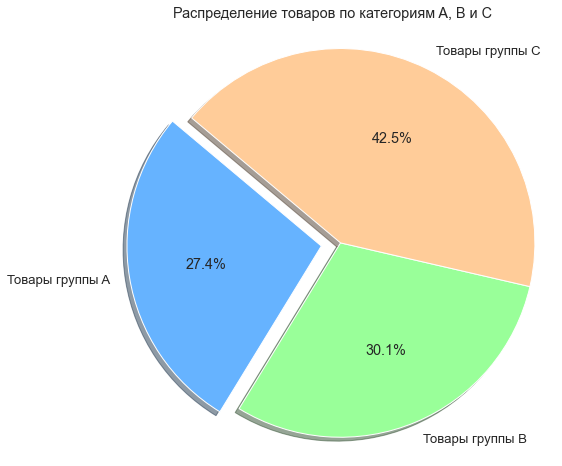

In [58]:
# Создаем данные для круговой диаграммы
labels = ['Товары группы A', 'Товары группы B', 'Товары группы C']
sizes = [len(group_A), len(group_B), len(group_C)]
colors = ['#66b3ff', '#99ff99', '#ffcc99']
explode = (0.1, 0, 0)  # Выделение первой группы

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Уравнивание осями для круга

plt.title('Распределение товаров по категориям A, B и C')

plt.show()

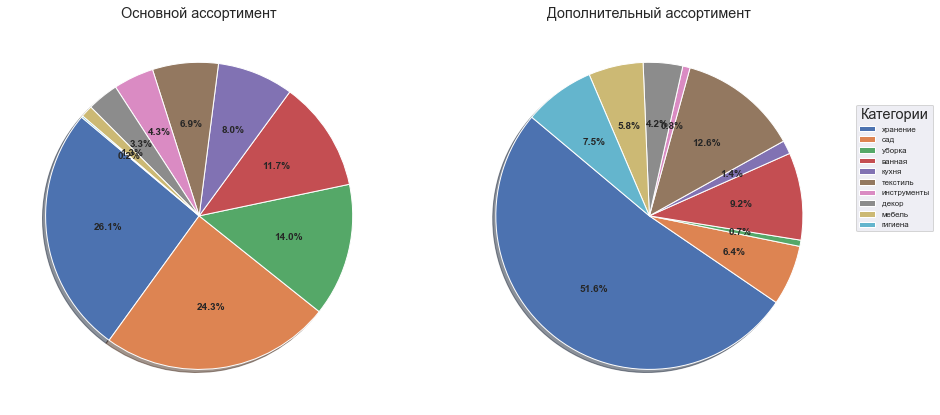

In [59]:
# Создаем датасет с информацией о категориях товаров
categories_df = df[['product', 'category']].drop_duplicates()

# Объединяем с датасетами групп A, B и C для получения информации о классификации товаров
group_A_categories = pd.merge(group_A, categories_df, on='product', how='left')
group_B_categories = pd.merge(group_B, categories_df, on='product', how='left')
group_C_categories = pd.merge(group_C, categories_df, on='product', how='left')

# Подсчет количества товаров в каждой категории для каждой группы
group_A_category_counts = group_A_categories['category'].value_counts()
group_B_category_counts = group_B_categories['category'].value_counts()
group_C_category_counts = group_C_categories['category'].value_counts()

# Создание двух круговых диаграмм для распределения категорий в группах
plt.figure(figsize=(14, 6))  # Увеличение размера диаграмм

# Круговая диаграмма для группы А
plt.subplot(1, 2, 1)
wedges_A, texts_A, autotexts_A = plt.pie(group_A_category_counts, autopct='%1.1f%%', shadow=True, startangle=140)
plt.setp(autotexts_A, size=10, weight='bold')  # Увеличение размера текста внутри секторов
plt.title('Основной ассортимент')

# Круговая диаграмма для групп B и C
plt.subplot(1, 2, 2)
wedges_B_C, texts_B_C, autotexts_B_C = plt.pie(group_B_category_counts + group_C_category_counts, autopct='%1.1f%%', shadow=True, startangle=140)
plt.setp(autotexts_B_C, size=10, weight='bold')  # Увеличение размера текста внутри секторов
plt.title('Дополнительный ассортимент')

# Общая легенда
plt.legend(wedges_A, group_A_category_counts.index, title='Категории', loc='upper right', bbox_to_anchor=(1.25, 0.8), fontsize=8)

plt.tight_layout()
plt.show()

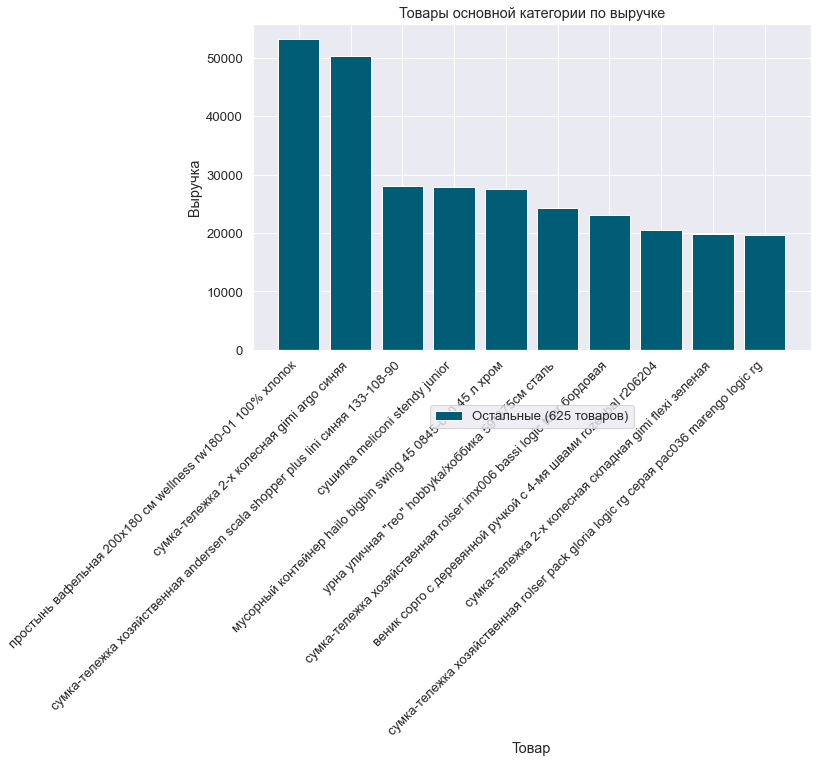

In [60]:
top_n = 10  # Количество лучших товаров для группы A

group_A_top = group_A.head(top_n)
other_revenue_A = group_A['revenue'].sum() - group_A_top['revenue'].sum()
other_label_A = f'Остальные ({len(group_A) - top_n} товаров)'

plt.figure(figsize=(10, 6))

# Создание столбцов для топ-10 товаров и остальных товаров
bars_A = plt.bar(group_A_top['product'], group_A_top['revenue'], color='#005d75')  # Изменен цвет столбцов
bars_A[-1].set_label(other_label_A)  # Добавляем отдельный столбец для "Остальных"

plt.xlabel('Товар')
plt.ylabel('Выручка')
plt.title('Товары основной категории по выручке')
plt.xticks(rotation=45, ha='right')

# Позиционирование легенды внизу
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

plt.tight_layout()
plt.show()

**Вывод**

**Основная категория** - товары группы A, дают 80% выручки.  

**Дополнительная категория** - товары групп В и С, в неё входят все оставшиеся товары, они формируют 20% выручки.


Видим, что львиную долю выручки приносят 2 вида товаров:
- простынь вафельная 200х180 см wellness rw180-01 100% хлопок
- сумка-тележка 2-х колесная gimi argo синяя

In [61]:
# Группировка данных по категориям и подсчет количества продуктов
category_prod = df.groupby('category').agg(products=('product', 'count')).reset_index()
category_prod.columns = ['category', 'products']

# Расчет отношения продуктов в каждой категории к общему числу продуктов
category_prod['ratio'] = ((category_prod['products'] / len(df)) * 100).round(1).astype('str') + '%'

# Сортировка по количеству продуктов в убывающем порядке
category_prod = category_prod.sort_values(by='products', ascending=False)

# Расчет накопительной суммы отношения продуктов
category_prod['ratio_cumsum'] = category_prod['ratio'].str.replace('%', '').astype(float).cumsum()
category_prod['ratio_cumsum'] = category_prod['ratio_cumsum'].round(1).astype(str) + '%'

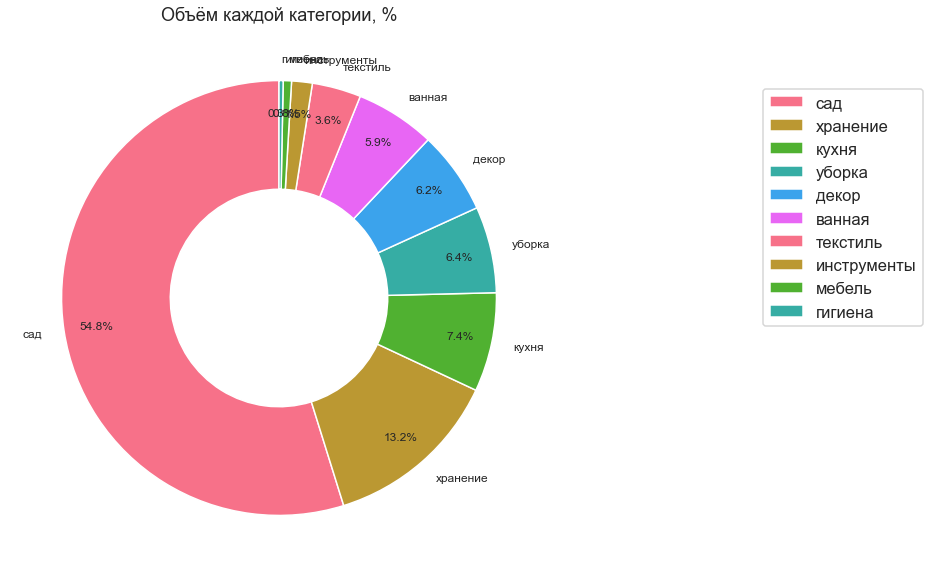

In [62]:
#Построим диаграмму
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('husl')

# Создание графика круговой диаграммы
plt.figure(figsize=(10, 10))
ax = plt.subplot()
wedges, texts, autotexts = ax.pie(category_prod['products'].values,
                                   labels=category_prod['category'].values,
                                   autopct='%1.1f%%',
                                   startangle=90,
                                   pctdistance=0.85,
                                   wedgeprops=dict(width=0.5),
                                   textprops=dict(size=12))

# Добавление значений отношения на диаграмму
for i, text in enumerate(texts):
    text.set_text(f"{category_prod.iloc[i]['category']}")

# Добавление значений отношения на секторы
for i, autotext in enumerate(autotexts):
    autotext.set_text(f"{category_prod.iloc[i]['ratio']}")

# Размещение легенды за пределами графика
plt.legend(wedges, category_prod['category'].values, bbox_to_anchor=(1.7, -0.1, 0, 1))
plt.title('Объём каждой категории, %', fontsize=18)
plt.show()

## Анализ товарного ассортимента

### Топ-5 товаров в каждой категории по количеству заказов за всё время

In [63]:
# Сгруппируем данные по наименованию товара для кажкой категории. 
groupby_product = df.groupby('product')\
                           .agg({'category':'first', 'order_id':'nunique', 'customer_id':'nunique', 
                                 'quantity':'sum', 'revenue':'sum'})\
                           .reset_index().sort_values(by='order_id', ascending=False)
groupby_product.columns = ['product', 'category', 'orders', 'customers', 'quantity', 'revenue']

# Найдем топ-5 самых продаваемых товаров в каждой категории по кол-ву заказов за весь период.
for category in groupby_product['category'].unique():
    print()
    display("ТОП-5 самых продаваемых товаров в категории по кол-ву заказов: «{}»".format(category))
    display(groupby_product[groupby_product['category']==category].head(5))
    print()

'ТОП-5 самых продаваемых товаров в категории по кол-ву заказов: «cад»'

product category  \
1031  пеларгония розебудная red pandora укорененный черенок    cад       
1029  пеларгония розебудная prins nikolai укорененный черенок  cад       
1003  пеларгония зональная диам. 12 см сиреневый полумахровый  cад       
1028  пеларгония розебудная mary укорененный черенок           cад       
1027  пеларгония розебудная margaretha укорененный черенок     cад       

      orders  customers  quantity  revenue  
1031  66      64         84       11330.33  
1029  56      55         65       8760.50   
1003  53      48         64       10949.00  
1028  40      36         48       6470.50   
1027  31      31         47       6356.67

'ТОП-5 самых продаваемых товаров в категории по кол-ву заказов: «хранение»'

product  \
1604  сумка-тележка 2-х колесная gimi argo синяя                                                                
1877  тележка багажная delta тбр-20 синий грузоподъемность 25 кг сумка и 50 кг каркас россия                    
1876  тележка багажная delta тбр-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас россия   
1613  сумка-тележка 2-х колесная складная gimi flexi зеленая                                                    
769   муляж баклажан 18 см                                                                                      

      category  orders  customers  quantity  revenue  
1604  хранение  47      43         47       50405.00  
1877  хранение  17      17         17       12453.75  
1876  хранение  16      14         17       11749.00  
1613  хранение  11      11         12       19788.00  
769   хранение  10      10         23       1357.00

'ТОП-5 самых продаваемых товаров в категории по кол-ву заказов: «уборка»'

product category  orders  \
1836  таз пластмассовый со стиральной доской иж 1404021  уборка   10       
288   гладильная доска ника дсп эконом 1065х29 эк1       уборка   7        
254   гладильная доска sarayli new elegant 125x45 см     уборка   7        
270   гладильная доска ника blues 124х46 см 5757         уборка   7        
273   гладильная доска ника lora fashion hlf 123х46 см   уборка   7        

      customers  quantity  revenue  
1836  10         10       3394.00   
288   6          17       7633.00   
254   6          7        17843.00  
270   7          7        17786.00  
273   5          7        13476.50

'ТОП-5 самых продаваемых товаров в категории по кол-ву заказов: «текстиль»'

product  \
2189  чехол для костюма 60х110 см rozenbal r261016                               
1127  подкладка под чехол zalger 520114 135х50 см войлок                         
1128  подкладка под чехол zalger 520140 135х50 см поролон                        
2157  чехол для гладильной доски attribute metal 140х60 см abm106                
2159  чехол для гладильной доски colombo persia beige 130х50 см из хлопка 5379   

      category  orders  customers  quantity  revenue  
2189  текстиль  8       7          10       1640.00   
1127  текстиль  7       7          9        1143.00   
1128  текстиль  6       6          6        762.00    
2157  текстиль  6       6          16       11778.67  
2159  текстиль  5       4          5        3370.00

'ТОП-5 самых продаваемых товаров в категории по кол-ву заказов: «декор»'

product category  orders  customers  \
819   муляж персики мини полиуретан d-6 см         декор    8       9           
831   муляж яблоко оранжевый 85 см полиуретан      декор    8       8           
2083  цветок искусственный крокус 20 см            декор    7       5           
792   муляж желудь 2 шт                            декор    6       7           
798   муляж красное яблоко мини полиуретан d-6 см  декор    6       6           

      quantity  revenue  
819   29       608.00    
831   54       2948.67   
2083  41       855.00    
792   26       572.00    
798   33       672.00

'ТОП-5 самых продаваемых товаров в категории по кол-ву заказов: «ванная»'

product  \
356   ерш унитазный с деревянной ручкой  ваир 1712012                      
640   корыто оцинкованное 45 л бесшовное 1303007                           
1485  сиденье в ванну раздвижное белый св5 ника                            
564   коврик хлопковый 40х60 см цвета в ассортименте 6194                  
2259  штора для ванной комнаты quadretto 240х200 см белая bacchetta 4062   

     category  orders  customers  quantity  revenue  
356   ванная   7       7          73       4103.00   
640   ванная   6       6          8        5992.00   
1485  ванная   6       7          8        2476.00   
564   ванная   5       4          12       1164.00   
2259  ванная   5       5          5        5995.00

'ТОП-5 самых продаваемых товаров в категории по кол-ву заказов: «кухня»'

product  \
682   кувшин пластмассовый с крышкой "кумган" 20 л 1408003                                  
928   овощеварка алюминиевая scovo мт-045 хозлэнд 1502079                                   
82    банка со стеклянной крышкой color series круглая 7*76*125 см 280 мл valiant jp-s280   
1898  термокружка яромир кремль яр-2406м 400 мл                                             
1453  салатник luminarc эмпилабль велада 17 см l7997                                        

     category  orders  customers  quantity  revenue  
682   кухня    5       5          5        745.00    
928   кухня    5       5          5        2245.00   
82    кухня    5       5          6        360.00    
1898  кухня    5       5          5        1603.00   
1453  кухня    5       5          5        820.00

'ТОП-5 самых продаваемых товаров в категории по кол-ву заказов: «инструменты»'

product     category  \
1597  стяжка оконная с болтом ст-55 цинк 1108354                инструменты   
100   бензин для зажигалок 1205214                              инструменты   
1595  стремянки colombo leonardo 2 ступени g300a02w серая 3646  инструменты   
1479  седум почвопокровный смесь окрасок объем 1 л              инструменты   
711   линейка длина 30 см truper rgl-30/14387                   инструменты   

      orders  customers  quantity  revenue  
1597  5       4          37       748.33    
100   4       4          6        402.00    
1595  3       2          3        8997.00   
1479  3       3          7        412.00    
711   3       3          3        741.00

'ТОП-5 самых продаваемых товаров в категории по кол-ву заказов: «мебель»'

product  \
469   карниз для ванной комнаты виолет раздвижной 280 см с кольцами бежевый 2810/2   
1135  подставка для обуви резиновая attribute 80x40 см amc080                        
466   карниз для ванной комнаты виолет раздвижной 210 см с кольцами белый 2110/6     
585   комод эльфпласт № 3 алфавит оранжевый 301о                                     
1134  подставка для ножей alpenkok круглая из пластика 11*22 см красная ak-202st     

     category  orders  customers  quantity  revenue  
469   мебель   4       3          5        1120.00   
1135  мебель   4       4          4        1416.00   
466   мебель   3       3          3        471.00    
585   мебель   3       2          3        4047.00   
1134  мебель   2       2          2        1454.00

'ТОП-5 самых продаваемых товаров в категории по кол-ву заказов: «гигиена»'

product  \
839   мыло ручной работы сувенир подарок на 8 марта классика                                                                 
2000  увлажняющая маска brown rice moisture 330 мл корея 599928                                                              
969   паста зубная для профилактики заболеваний десен kobayashi японский кипарис и белая береза 100 г япония 4987072072752   
375   зубная паста systema tartar против образования зубного камня 120 г корея 8806325-616764                                
376   зубная паста zact lion smokers toothpaste 100 г 8850002805040                                                          

     category  orders  customers  quantity  revenue  
839   гигиена  3       3          13       884.00    
2000  гигиена  2       2          2        884.00    
969   гигиена  2       2          6        5394.00   
375   гигиена  2       2          3        582.00    
376   гигиена  1       1          1        134.00

**Вывод**


- В категории «cад» самый продаваемый товар: пеларгония розебудная red pandora
- В категории «хранение» самый продаваемый товар: сумка-тележка 2-х колесная gimi argo синяя
- В категории «уборка» самый продаваемый товар: таз пластмассовый со стиральной доской
- В категории «декор» самый продаваемый товар: муляж яблоко оранжевый 85 см полиуретан
- В категории «текстиль» самый продаваемый товар: чехол для костюма 60х110 см rozenbal
- В категории «ванная» самый продаваемый товар: коврик придверный хлопковый 60х140 см
- В категории «кухня» самый продаваемый товар: кувшин пластмассовый с крышкой "кумган" 20 л
- В категории «мебель» самый продаваемый товар: карниз для ванной комнаты виолет раздвижной
- В категории «инструменты» самый продаваемый товар: стяжка оконная с болтом ст-55 цинк 1
- В категории «гигиена» самый продаваемый товар: мыло ручной работы сувенир подарок на 8 марта классика

### Топ-5 прибыльных товаров в каждой категории за всё время

In [64]:
groupby_product_rev = df.groupby(['category', 'product']) \
                        .agg({'order_id': 'nunique', 'customer_id': 'nunique', 'quantity': 'sum', 'revenue': 'sum'}) \
                        .reset_index().sort_values(by=['category', 'revenue'], ascending=[True, False])
groupby_product_rev.columns = ['category', 'product', 'orders', 'customers', 'quantity', 'revenue']

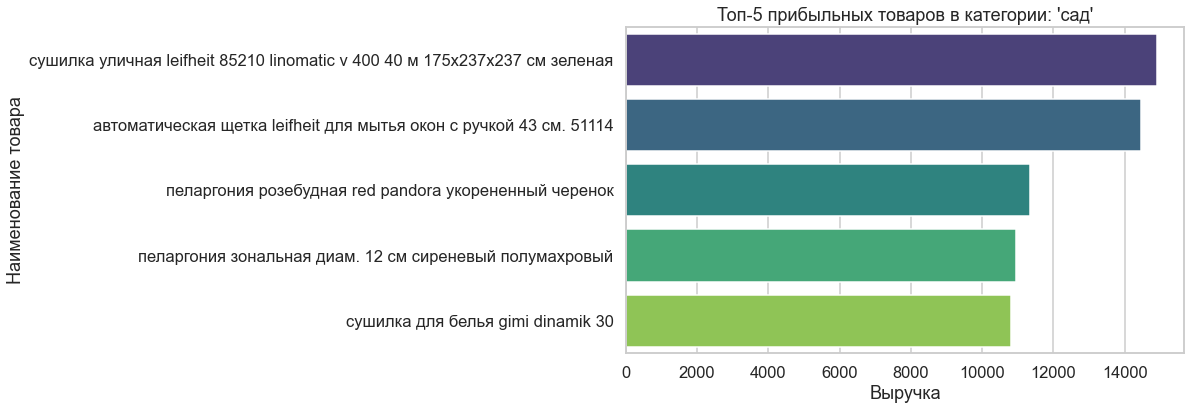

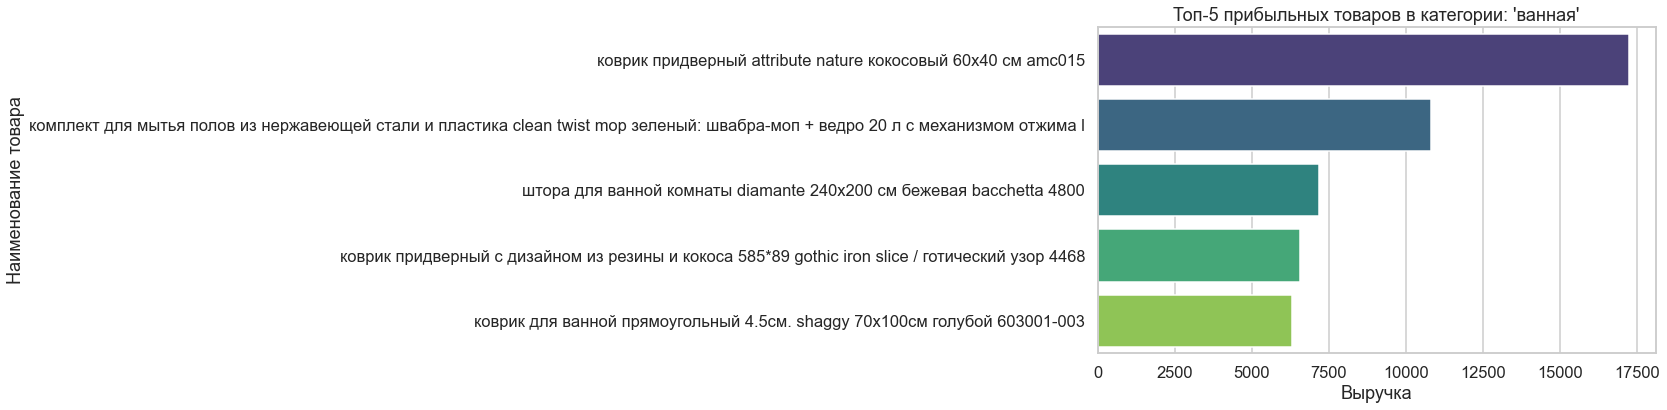

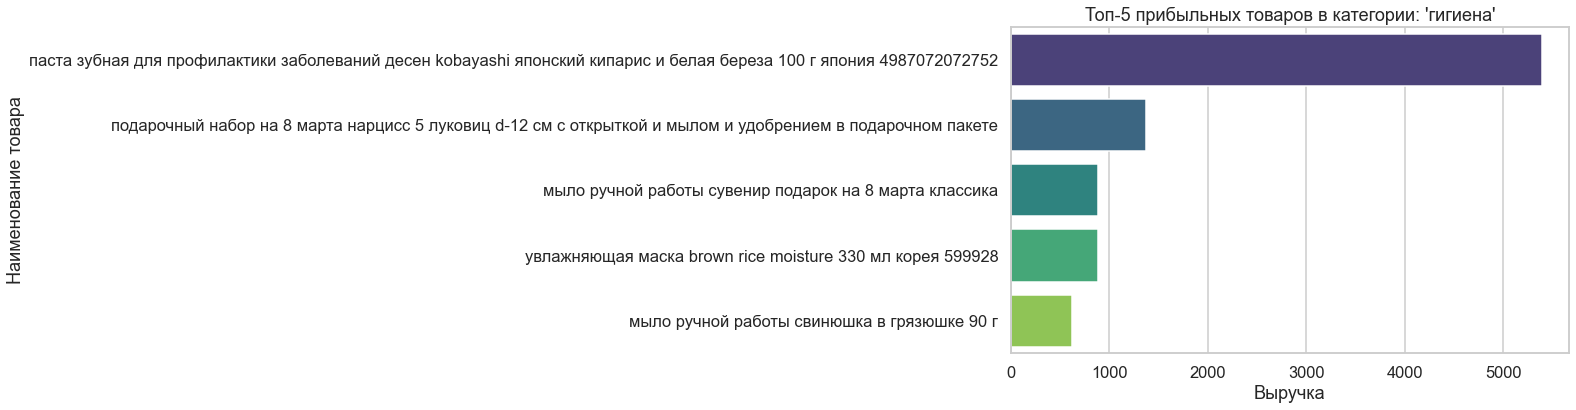

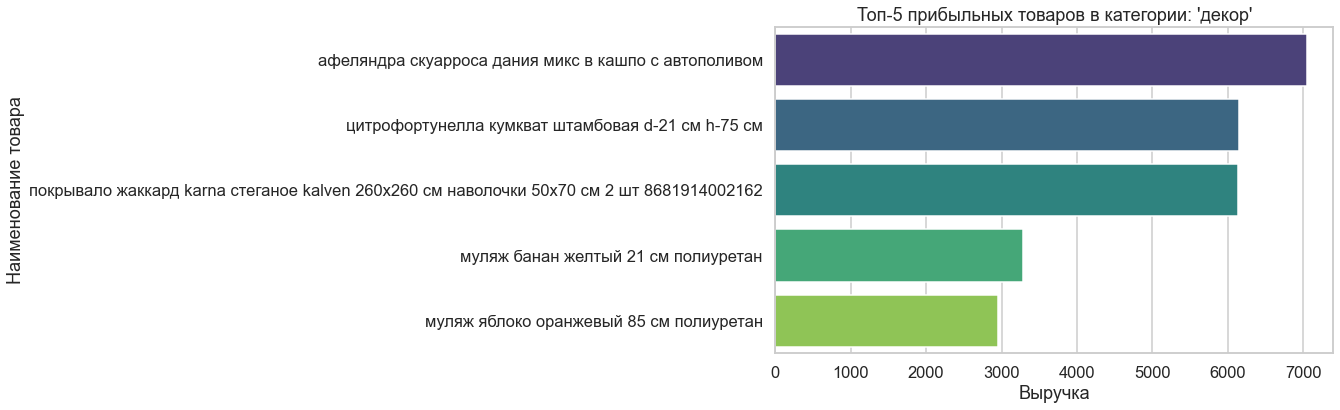

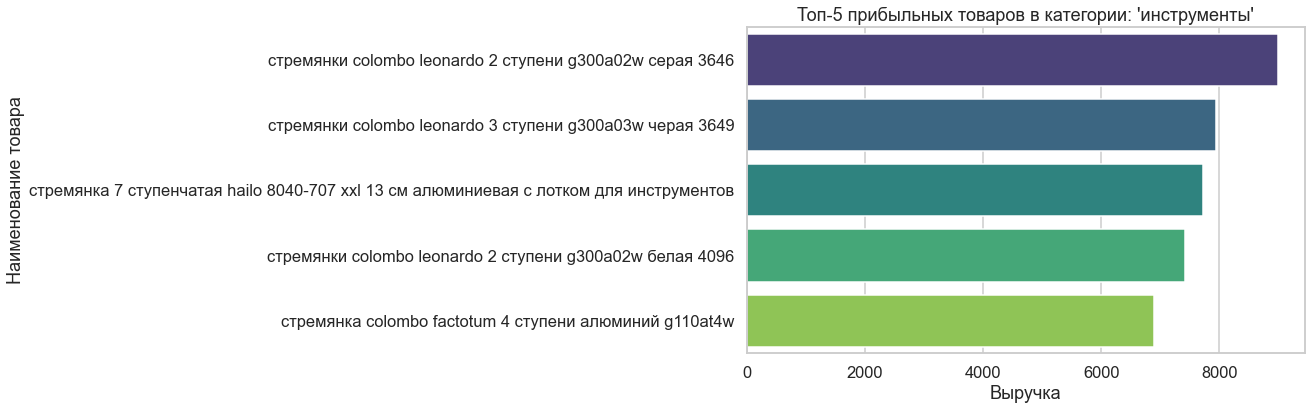

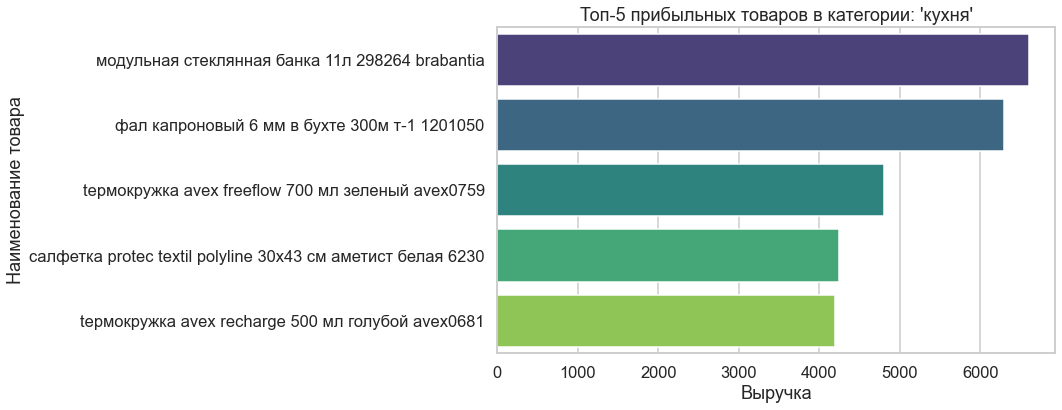

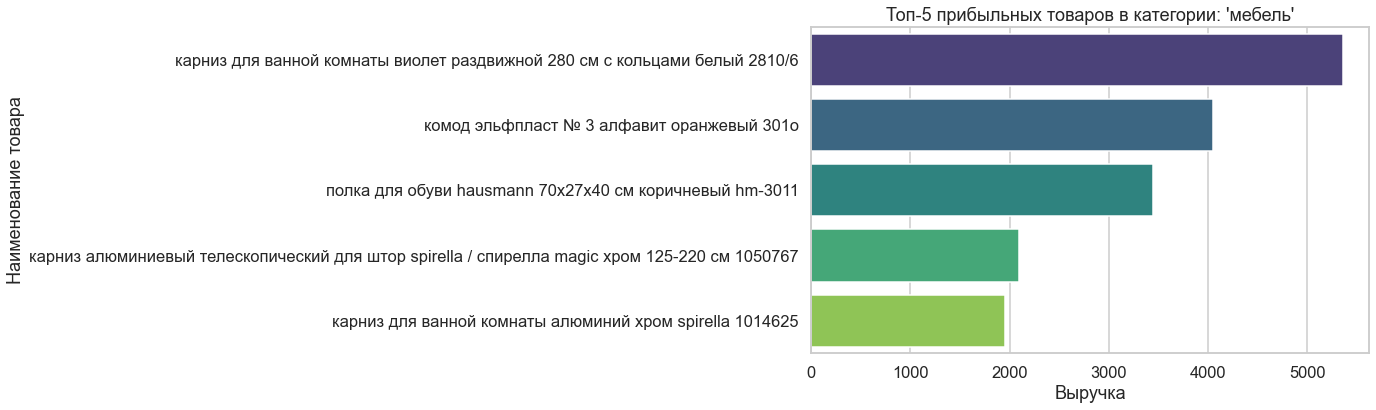

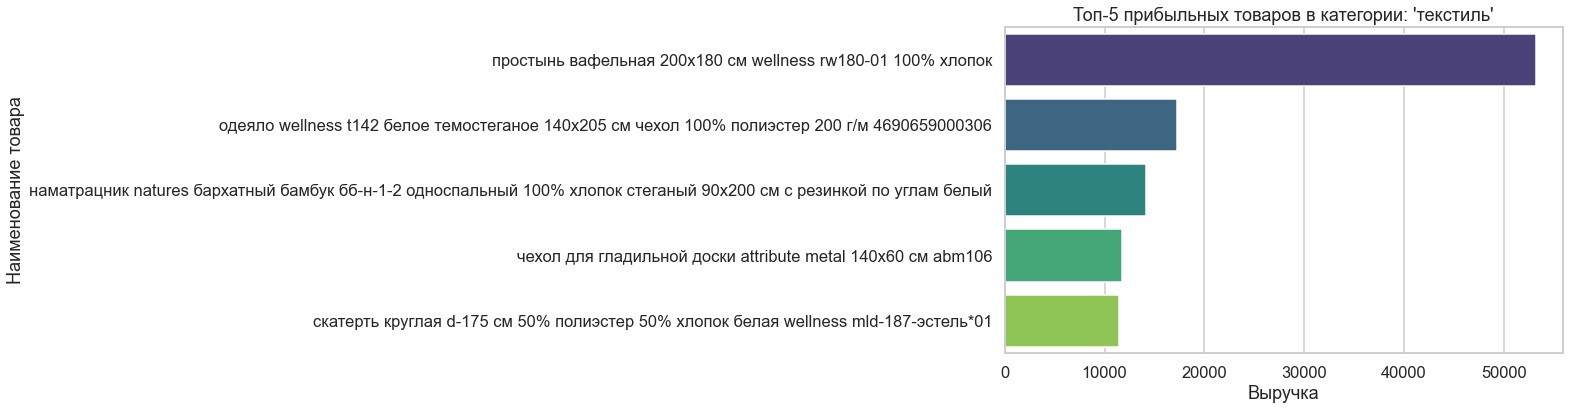

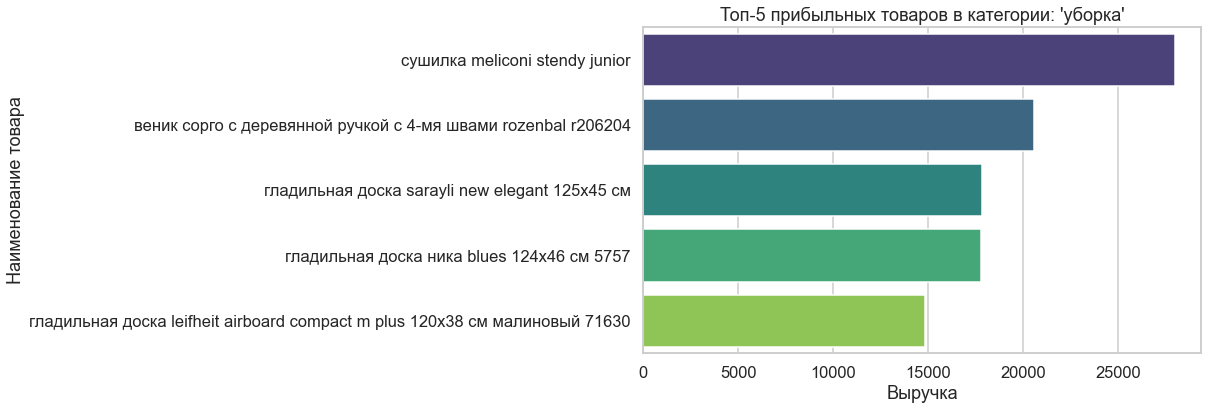

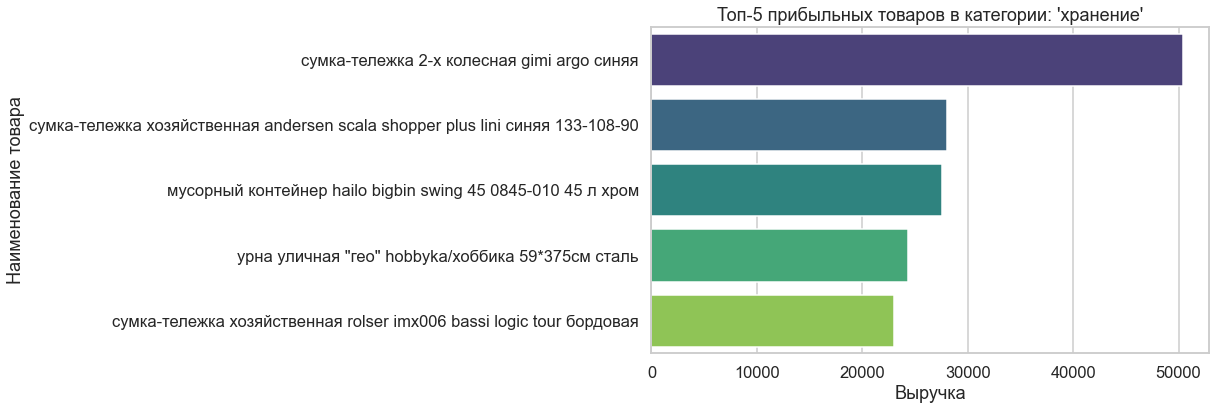

In [65]:
def plot_top_5_products_by_category(data):
    for category in data['category'].unique():
        plt.figure(figsize=(10, 6))
        sns.barplot(x='revenue', y='product', data=data[data['category']==category].head(5), palette='viridis')
        plt.title(f"Топ-5 прибыльных товаров в категории: '{category}'")
        plt.xlabel("Выручка")
        plt.ylabel("Наименование товара")
        plt.show()

# Построение графиков Топ-5 прибыльных товаров по каждой категории
plot_top_5_products_by_category(groupby_product_rev)

In [66]:
# Найдем Топ-5 самых прибыльных товаров в каждой категории за весь период.
for category in groupby_product_rev['category'].unique():
    print()
    display("ТОП-5 самых прибыльных товаров в категории: «{}»".format(category))
    display(groupby_product_rev[groupby_product_rev['category']==category].head(5))
    print()

'ТОП-5 самых прибыльных товаров в категории: «cад»'

category  \
831  cад       
0    cад       
391  cад       
363  cад       
736  cад       

                                                                        product  \
831  сушилка уличная leifheit 85210 linomatic v 400 40 м 175х237х237 см зеленая   
0    автоматическая щетка leifheit для мытья окон с ручкой 43 см. 51114           
391  пеларгония розебудная red pandora укорененный черенок                        
363  пеларгония зональная диам. 12 см сиреневый полумахровый                      
736  сушилка для белья gimi dinamik 30                                            

     orders  customers  quantity  revenue  
831  1       1          1        14917.00  
0    2       2          2        14458.00  
391  66      64         84       11330.33  
363  53      48         64       10949.00  
736  4       3          4        10796.00

'ТОП-5 самых прибыльных товаров в категории: «ванная»'

category  \
1077  ванная    
1118  ванная    
1180  ванная    
1098  ванная    
1070  ванная    

                                                                                                                              product  \
1077  коврик придверный attribute nature кокосовый 60x40 см amc015                                                                      
1118  комплект для мытья полов из нержавеющей стали и пластика clean twist mop зеленый: швабра-моп + ведро 20 л с механизмом отжима l   
1180  штора для ванной комнаты diamante 240х200 см бежевая bacchetta 4800                                                               
1098  коврик придверный с дизайном из резины и кокоса 585*89 gothic iron slice / готический узор 4468                                   
1070  коврик для ванной прямоугольный 4.5см. shaggy 70х100см голубой 603001-003                                                         

      orders  customers  quantity  revenue  
1077  5       5          55       17227.50  
1118  2       2          2        10798.00  
1180  3       3          6        7194.00   
1098  3       4          4        6568.00   
1070  2       2          3        6297.00

'ТОП-5 самых прибыльных товаров в категории: «гигиена»'

category  \
1212  гигиена   
1213  гигиена   
1210  гигиена   
1214  гигиена   
1209  гигиена   

                                                                                                                   product  \
1212  паста зубная для профилактики заболеваний десен kobayashi японский кипарис и белая береза 100 г япония 4987072072752   
1213  подарочный набор на 8 марта нарцисс 5 луковиц d-12 см с открыткой и мылом и удобрением в подарочном пакете             
1210  мыло ручной работы сувенир подарок на 8 марта классика                                                                 
1214  увлажняющая маска brown rice moisture 330 мл корея 599928                                                              
1209  мыло ручной работы свинюшка в грязюшке 90 г                                                                            

      orders  customers  quantity  revenue  
1212  2       2          6        5394.00   
1213  1       1          4        1376.00   
1210  3       3          13       884.00    
1214  2       2          2        884.00    
1209  1       1          8        624.00

'ТОП-5 самых прибыльных товаров в категории: «декор»'

category  \
1228  декор     
1383  декор     
1347  декор     
1283  декор     
1330  декор     

                                                                                       product  \
1228  афеляндра скуарроса дания микс в кашпо с автополивом                                       
1383  цитрофортунелла кумкват штамбовая d-21 см h-75 см                                          
1347  покрывало жаккард karna стеганое kalven 260x260 см наволочки 50х70 см 2 шт 8681914002162   
1283  муляж банан желтый 21 см полиуретан                                                        
1330  муляж яблоко оранжевый 85 см полиуретан                                                    

      orders  customers  quantity  revenue  
1228  2       2          2        7048.00   
1383  2       2          2        6148.00   
1347  1       1          1        6134.00   
1283  5       5          59       3281.00   
1330  8       8          54       2948.67

'ТОП-5 самых прибыльных товаров в категории: «инструменты»'

category  \
1433  инструменты   
1434  инструменты   
1413  инструменты   
1432  инструменты   
1416  инструменты   

                                                                                     product  \
1433  стремянки colombo leonardo 2 ступени g300a02w серая 3646                                 
1434  стремянки colombo leonardo 3 ступени g300a03w черая 3649                                 
1413  стремянка 7 ступенчатая hailo 8040-707 xxl 13 см алюминиевая с лотком для инструментов   
1432  стремянки colombo leonardo 2 ступени g300a02w белая 4096                                 
1416  стремянка colombo factotum 4 ступени алюминий g110at4w                                   

      orders  customers  quantity  revenue  
1433  3       2          3        8997.00   
1434  2       2          2        7948.00   
1413  1       1          1        7724.00   
1432  2       2          2        7424.00   
1416  2       1          2        6898.00

'ТОП-5 самых прибыльных товаров в категории: «кухня»'

category                                                      product  \
1531  кухня    модульная стеклянная банка 11л 298264 brabantia               
1673  кухня    фал капроновый 6 мм в бухте 300м т-1 1201050                  
1443  кухня    tepмокружка avex freeflow 700 мл зеленый avex0759             
1594  кухня    салфетка protec textil polyline 30х43 см аметист белая 6230   
1445  кухня    tepмокружка avex recharge 500 мл голубой avex0681             

      orders  customers  quantity  revenue  
1531  2       2          8        6600.00   
1673  3       3          3        6297.00   
1443  2       2          2        4798.00   
1594  3       3          20       4240.00   
1445  2       2          2        4198.00

'ТОП-5 самых прибыльных товаров в категории: «мебель»'

category  \
1714  мебель    
1717  мебель    
1724  мебель    
1708  мебель    
1709  мебель    

                                                                                            product  \
1714  карниз для ванной комнаты виолет раздвижной 280 см с кольцами белый 2810/6                      
1717  комод эльфпласт № 3 алфавит оранжевый 301о                                                      
1724  полка для обуви hausmann 70х27х40 см коричневый hm-3011                                         
1708  карниз алюминиевый телескопический для штор spirella / спирелла magic хром 125-220 см 1050767   
1709  карниз для ванной комнаты алюминий хром spirella 1014625                                        

      orders  customers  quantity  revenue  
1714  2       2          25       5360.00   
1717  3       2          3        4047.00   
1724  1       1          2        3448.00   
1708  1       1          1        2099.00   
1709  1       1          1        1949.00

'ТОП-5 самых прибыльных товаров в категории: «текстиль»'

category  \
1764  текстиль   
1755  текстиль   
1751  текстиль   
1797  текстиль   
1787  текстиль   

                                                                                                                  product  \
1764  простынь вафельная 200х180 см wellness rw180-01 100% хлопок                                                           
1755  одеяло wellness t142 белое темостеганое 140х205 см чехол 100% полиэстер 200 г/м 4690659000306                         
1751  наматрацник natures бархатный бамбук бб-н-1-2 односпальный 100% хлопок стеганый 90х200 см с резинкой по углам белый   
1797  чехол для гладильной доски attribute metal 140х60 см abm106                                                           
1787  скатерть круглая d-175 см 50% полиэстер 50% хлопок белая wellness mld-187-эстель*01                                   

      orders  customers  quantity  revenue  
1764  2       1          30       53232.00  
1755  2       2          11       17248.00  
1751  1       1          12       14196.00  
1797  6       6          16       11778.67  
1787  1       1          10       11400.00

'ТОП-5 самых прибыльных товаров в категории: «уборка»'

category  \
1975  уборка    
1845  уборка    
1868  уборка    
1884  уборка    
1865  уборка    

                                                                          product  \
1975  сушилка meliconi stendy junior                                                
1845  веник сорго с деревянной ручкой с 4-мя швами rozenbal r206204                 
1868  гладильная доска sarayli new elegant 125x45 см                                
1884  гладильная доска ника blues 124х46 см 5757                                    
1865  гладильная доска leifheit airboard compact m plus 120х38 см малиновый 71630   

      orders  customers  quantity  revenue  
1975  5       5          5        27970.00  
1845  3       3          38       20550.00  
1868  7       6          7        17843.00  
1884  7       7          7        17786.00  
1865  2       2          2        14848.00

'ТОП-5 самых прибыльных товаров в категории: «хранение»'

category  \
2189  хранение   
2219  хранение   
2146  хранение   
2297  хранение   
2243  хранение   

                                                                            product  \
2189  сумка-тележка 2-х колесная gimi argo синяя                                      
2219  сумка-тележка хозяйственная andersen scala shopper plus lini синяя 133-108-90   
2146  мусорный контейнер hailo bigbin swing 45 0845-010 45 л хром                     
2297  урна уличная "гео" hobbyka/хоббика 59*375см сталь                               
2243  сумка-тележка хозяйственная rolser imx006 bassi logic tour бордовая             

      orders  customers  quantity  revenue  
2189  47      43         47       50405.00  
2219  5       5          5        28045.00  
2146  3       3          5        27560.00  
2297  1       1          5        24370.00  
2243  2       2          3        23037.00

**Вывод**

- В категории «текстиль» самый прибыльный товар: простынь вафельная 200х180 см wellness
- В категории «хранение» самый прибыльный товар: сумка-тележка 2-х колесная gimi
- В категории «уборка» самый прибыльный товар: сушилка meliconi stendy junior
- В категории «ванная» самый прибыльный товар: коврик придверный attribute nature кокосовый
- В категории «cад» самый прибыльный товар: сушилка уличная leifheit 85210 linomatic
- В категории «инструменты» самый прибыльный товар: стремянка colombo leonardo 2 ступени
- В категории «кухня» самый прибыльный товар: модульная стеклянная банка
- В категории «гигиена» самый прибыльный товар: паста зубная для профилактики заболеваний десен kobayashi японский кипарис
- В категории «мебель» самый прибыльный товар: карниз для ванной комнаты виолет раздвижной
- В категории «декор» самый прибыльный товар: афеляндра скуарроса дания микс в кашпо с автополивом

### Посчитаем выручку и количество покупателей по категориям товара

In [67]:
# Сгруппируем данные по категориям
groupby_category = df.groupby('category').agg({'revenue':'sum', 'date':'max', 'order_id':'nunique',
                                                      'customer_id':'nunique', 'quantity':'sum'})
groupby_category.columns = ['revenue', 'date', 'orders', 'customers', 'quantity'] # переименуем столбцы 

# Найдём средний чек покупателя  
groupby_category['revenue_per_customer'] = groupby_category['revenue'] / groupby_category['customers']

# Найдём средний чек заказов  
groupby_category['revenue_per_order'] = groupby_category['revenue'] / groupby_category['orders']
groupby_category = groupby_category.sort_values(by='revenue', ascending = False)

# Найдем соотношение выручки, покупателей, заказов от их общего количества 
groupby_category['ratio_revenue'] = ((groupby_category['revenue'] / groupby_category['revenue'].sum())* 100)\
                                                                                    .round(1).astype('str')+'%'
groupby_category['ratio_customer']= ((groupby_category['customers'] / groupby_category['customers'].sum())* 100)\
                                                                                     .round(1).astype('str')+'%'
groupby_category['ratio_order']= ((groupby_category['orders'] / groupby_category['orders'].sum())* 100)\
                                                                                     .round(1).astype('str')+'%'
display(groupby_category)

revenue        date  orders  customers  quantity  \
category                                                          
хранение    1197717.25  2020-01-31  673     591        1192       
cад         884666.50   2020-01-31  1382    1147       4640       
уборка      461294.50   2020-01-29  331     293        616        
ванная      329444.50   2020-01-29  307     273        592        
текстиль    281065.17   2020-01-26  191     169        341        
кухня       238320.00   2020-01-29  350     326        909        
инструменты 120540.33   2020-01-22  80      77         162        
декор       117492.17   2020-01-27  263     255        1020       
мебель      31051.00    2020-01-31  34      32         60         
гигиена     11155.00    2020-01-05  16      16         46         

             revenue_per_customer  revenue_per_order ratio_revenue  \
category                                                             
хранение    2026.59               1779.67             32.6%          
cад         771.29                640.13              24.1%          
уборка      1574.38               1393.64             12.6%          
ванная      1206.76               1073.11             9.0%           
текстиль    1663.11               1471.55             7.7%           
кухня       731.04                680.91              6.5%           
инструменты 1565.46               1506.75             3.3%           
декор       460.75                446.74              3.2%           
мебель      970.34                913.26              0.8%           
гигиена     697.19                697.19              0.3%           

            ratio_customer ratio_order  
category                                
хранение     18.6%          18.6%       
cад          36.1%          38.1%       
уборка       9.2%           9.1%        
ванная       8.6%           8.5%        
текстиль     5.3%           5.3%        
кухня        10.3%          9.6%        
инструменты  2.4%           2.2%        
декор        8.0%           7.3%        
мебель       1.0%           0.9%        
гигиена      0.5%           0.4%

#### Построим диаграммы количества заказов, суммы выручки и  среднего чека заказа по категориям

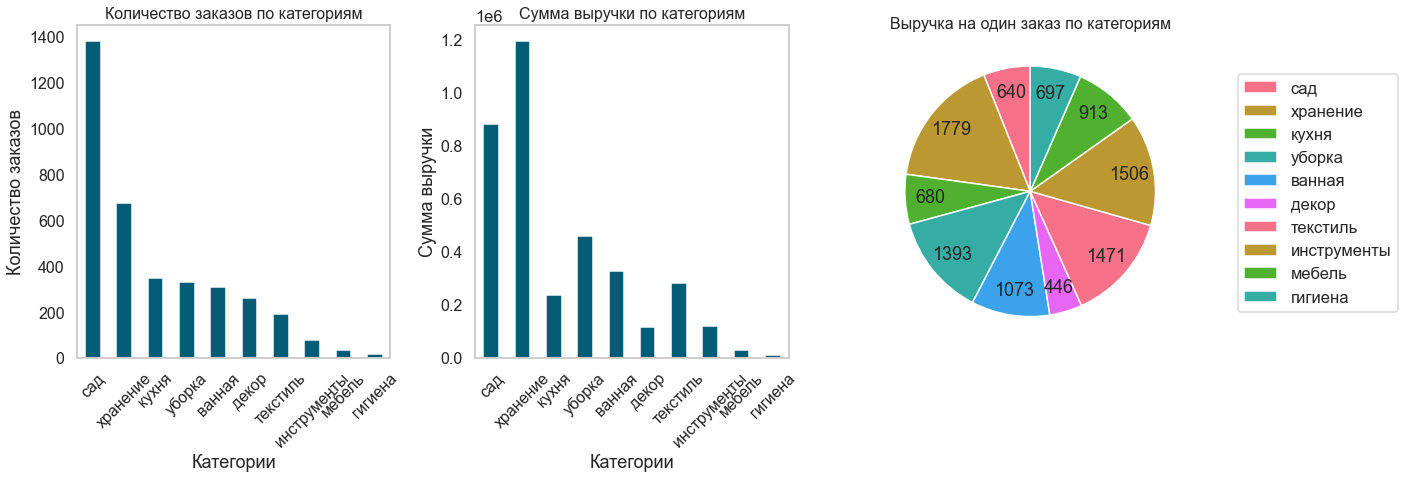

In [68]:
groupby_category = groupby_category.sort_values(by='orders', ascending=False)

# Установка стилей и цветов
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('husl')

# Создание сетки subplot для размещения диаграмм
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

# Первая диаграмма: количество заказов по категориям
groupby_category.plot(kind='bar', y='orders', ax=axs[0], grid=False, color='#005d75',
                             fontsize=16, legend=False, rot=45)
axs[0].set_title('Количество заказов по категориям', fontsize=16)
axs[0].set_xlabel('Категории')
axs[0].set_ylabel('Количество заказов')

# Вторая диаграмма: сумма выручки по категориям
groupby_category.plot(kind='bar', y='revenue', ax=axs[1], grid=False, color='#005d75',
                             fontsize=16, legend=False, rot=45)
axs[1].set_title('Сумма выручки по категориям', fontsize=16)
axs[1].set_xlabel('Категории')
axs[1].set_ylabel('Сумма выручки')

# Третья диаграмма: выручка на один заказ по категориям (в виде круговой диаграммы)
wedges, _ = axs[2].pie(groupby_category['revenue_per_order'].values, pctdistance=0.6,
                        labels=None, explode=np.zeros(len(groupby_category)), startangle=90)

# Добавление значений выручки на один заказ на секторы
for i, wedge in enumerate(wedges):
    category = groupby_category.index[i]
    revenue_per_order = groupby_category.iloc[i]['revenue_per_order']
    # Вычисление координат для размещения текста на секторе
    angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
    x = 0.8 * wedge.r * np.cos(np.deg2rad(angle))
    y = 0.8 * wedge.r * np.sin(np.deg2rad(angle))
    axs[2].text(x, y, f"{int(revenue_per_order)}", ha='center', va='center')

# Добавление названий категорий за пределами диаграммы
axs[2].legend(wedges, groupby_category.index, bbox_to_anchor=(1.7, -0.1, 0, 1))

# Заголовок для третьей диаграммы
axs[2].set_title('Выручка на один заказ по категориям', fontsize=16)

# Отображение графиков
plt.tight_layout()
plt.show()

Круговая диаграмма среднего чека заказов по категориям

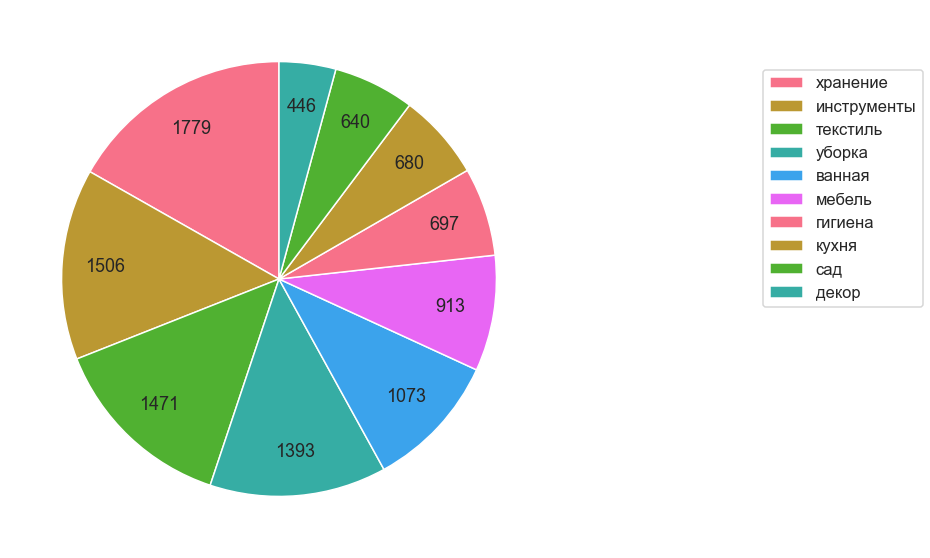

In [69]:
groupby_category_sorted = groupby_category.sort_values(by='revenue_per_order', ascending=False)

sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('husl')

plt.figure(figsize=(10, 10))
ax = plt.subplot()
wedges, _ = ax.pie(groupby_category_sorted['revenue_per_order'].values, pctdistance=0.6,
                   labels=None, explode=np.zeros(len(groupby_category_sorted)), startangle=90)

# Добавление значений среднего чека на секторы
for i, wedge in enumerate(wedges):
    category = groupby_category_sorted.index[i]
    revenue_per_order = groupby_category_sorted.iloc[i]['revenue_per_order']
    # Вычисление координат для размещения текста на секторе
    angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
    x = 0.8 * wedge.r * np.cos(np.deg2rad(angle))
    y = 0.8 * wedge.r * np.sin(np.deg2rad(angle))
    plt.text(x, y, f"{int(revenue_per_order)}", ha='center', va='center')

# Добавление названий категорий за пределами диаграммы
plt.legend(wedges, groupby_category_sorted.index, bbox_to_anchor=(1.7, -0.1, 0, 1))

plt.show()

**Вывод**

По сумме выручки, самая прибыльная категория — это «хранение», затем идут категории «сад» и «инструменты». Наименее прибыльная категория «гигиена».


По количеству заказов, самые продаваемые товары категории «сад», затем идет категория «хранение», что подтверждает основной товарный ассортимент — это категория «сад», а остальные — дополнительные.


По среднему чеку, как показателю эффективности продаж, категория «сад» дает самую малую выручку. Чтобы улучшить данный показатель предложим ввести кросс-продажи, предлагать клиентам магазина сопутствующий товар со скидкой. Можно работать с ассортиментом и его сортировкой, предлагая позиции дороже среднего чека. Проводить акции и давать спецпредложения.

**Основной доход интернет-магазина от категорий «хранение», «текстиль», «инструменты» и «уборка»**

### Оценим сезонность продаж товаров по категориям

In [70]:
#Создадим копию датасета
df_1 = df.copy()

In [71]:
#Функция, принимающая номер месяца и возвращающая время года
def season(month):
    if  3 <= month <= 5:
        return 'весна'
    elif 6 <= month <= 8:
        return 'лето'
    elif 9 <= month <= 11:
        return 'осень'
    else:
        return 'зима'

In [72]:
# Cоздадим отдельный столбец с временами года  
df['season'] = df['month'].apply(season)
display(df.shape)
df.sample(3)

(5530, 18)

datetime                           customer_id  order_id  \
2964 2019-04-19 16:00:00  5f6d318b-4ed0-4163-8767-2959bc2e6c76  14663      
784  2018-11-12 10:00:00  db871094-56a6-4cbd-9287-fdd33cc328cb  68965      
6258 2019-09-05 14:00:00  51851f8e-e239-4e31-ab2c-4b67ab2c76da  72517      

                                                                             product  \
2964  рассада зелени для кухни тимьян цитриодорус диам. 9 см                           
784   герань домашняя пеларгония зональная цветущая d12 h25-30 ярко красная махровая   
6258  бальзамин новогвинейский d-13 см лососевый                                       

      quantity  price  revenue  hour  day  week  month  year        date  \
2964  1        120.00 120.00    16    5    16    4      2019  2019-04-19   
784   1        149.00 149.00    10    1    46    11     2018  2018-11-12   
6258  1        134.00 134.00    14    4    36    9      2019  2019-09-05   

      weekdays  weekends category      assortment season  
2964  1         0         cад      дополнительный  весна  
784   1         0         cад      дополнительный  осень  
6258  1         0         cад      дополнительный  осень

#### Сезонность продаж товаров  

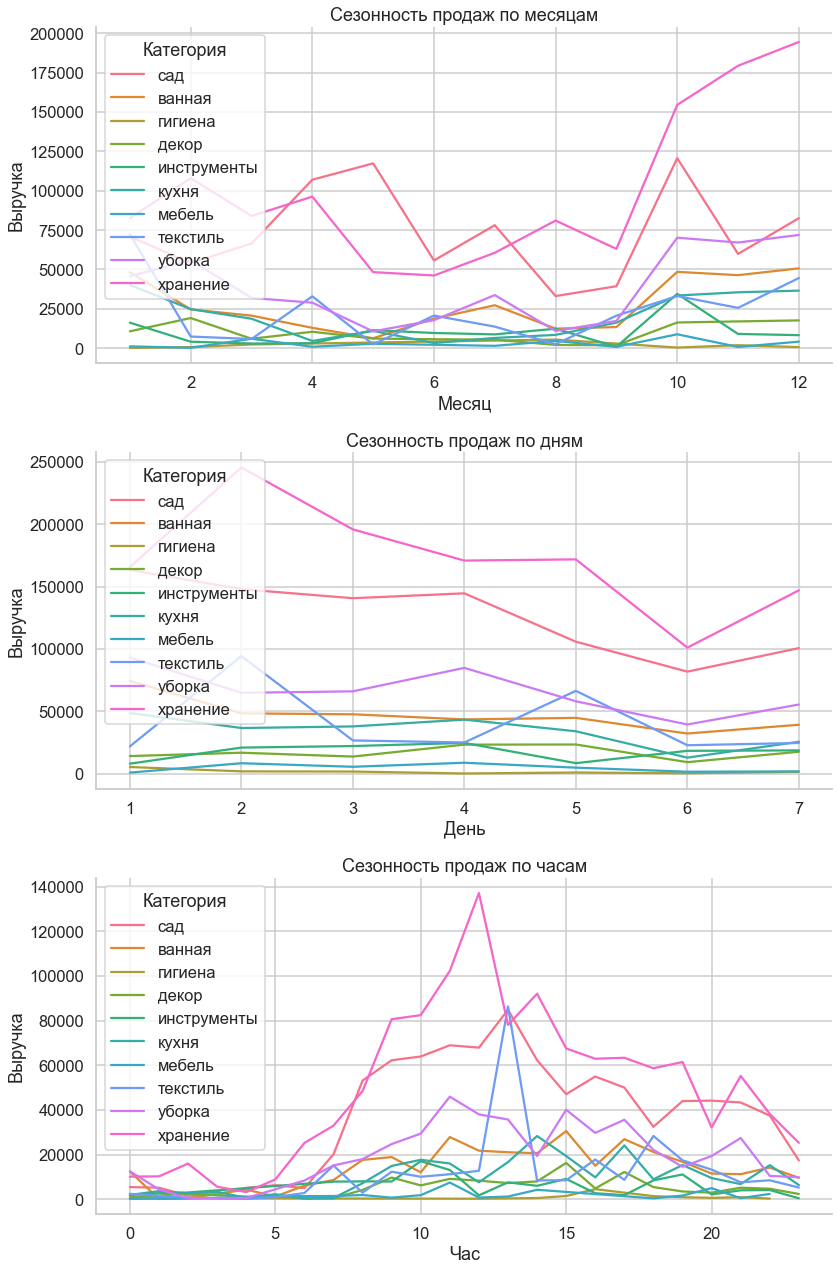

In [73]:
# Группировка данных по категориям и временным параметрам
grouped_month = df.groupby(['category', 'month'])['revenue'].sum().reset_index()
grouped_day = df.groupby(['category', 'day'])['revenue'].sum().reset_index()
grouped_hour = df.groupby(['category', 'hour'])['revenue'].sum().reset_index()

# Создание фигуры и осей для линейных диаграмм
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

# Построение линейных диаграмм для сезонности продаж по месяцам, дням и часам
sns.set_palette("Set1")  # Выбор палитры цветов
sns.set_style("whitegrid")  # Изменение стиля графика
sns.despine()  # Убрать спинку графика

sns.lineplot(data=grouped_month, x='month', y='revenue', hue='category', ax=axes[0])
sns.lineplot(data=grouped_day, x='day', y='revenue', hue='category', ax=axes[1])
sns.lineplot(data=grouped_hour, x='hour', y='revenue', hue='category', ax=axes[2])

# Настройка заголовков и подписей
axes[0].set_title('Сезонность продаж по месяцам')
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Выручка')

axes[1].set_title('Сезонность продаж по дням')
axes[1].set_xlabel('День')
axes[1].set_ylabel('Выручка')

axes[2].set_title('Сезонность продаж по часам')
axes[2].set_xlabel('Час')
axes[2].set_ylabel('Выручка')

# Легенда
for ax in axes:
    ax.legend(title='Категория', loc='upper left')

# Отображение линейных диаграмм
plt.tight_layout()
plt.show()

**Вывод**

- С сентября по декабрь видим резкий рост продаж товаров категорий "сад", "хранение" и "уборка"
- По дням недели товары лучше продаютя в понедельник и вторник
- По часам, пик активности с 9 до 15 часов

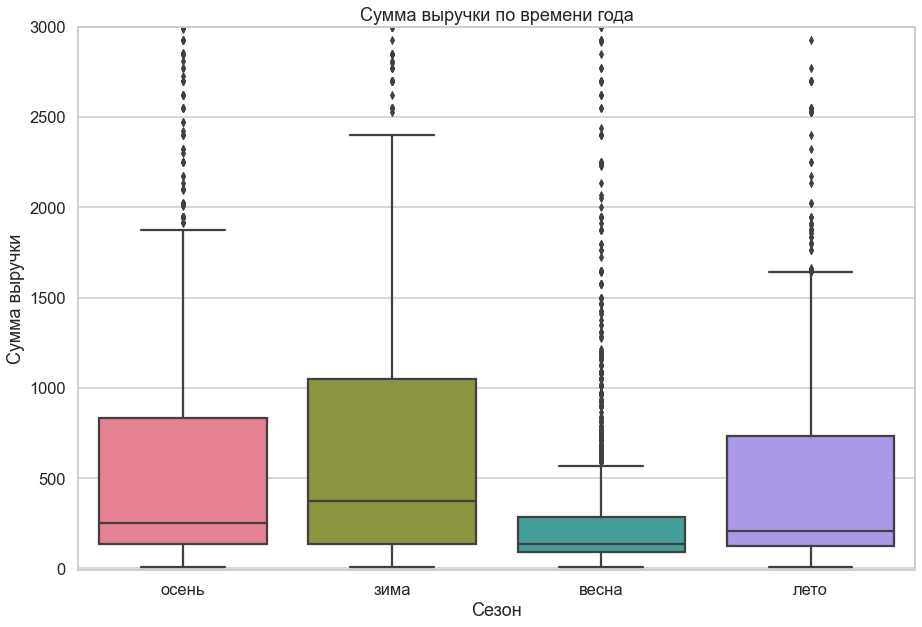

In [74]:
# Построим график боксплот выручки по времени года
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_style('whitegrid')
sns.set_context('talk')
sns.boxplot(x='season', y='revenue', data=df, palette='husl').set_ylim(-10, 3000)
plt.title('Сумма выручки по времени года', fontsize=18)
plt.xlabel('Сезон')
plt.ylabel('Сумма выручки')
plt.show()

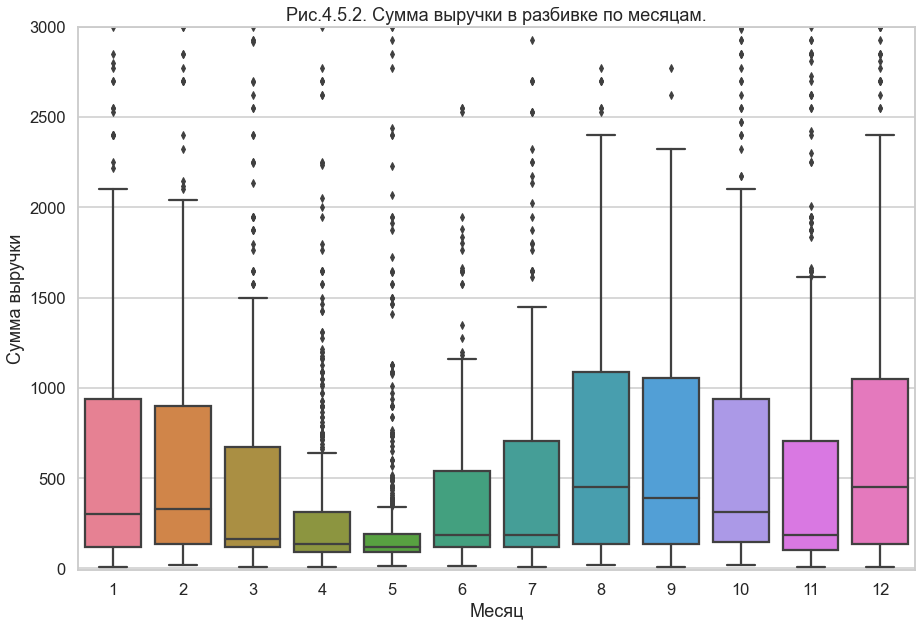

In [75]:
# Построим боксплот выручки по месяцам
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_style('whitegrid')  
sns.set_context('talk')
sns.boxplot(x='month', y='revenue', data=df, palette='husl').set_ylim(-10, 3000)
plt.title('Рис.4.5.2. Сумма выручки в разбивке по месяцам.', fontsize=18)
plt.xlabel('Месяц')
plt.ylabel('Сумма выручки')
plt.show()

In [76]:
# Создадим датасеты по категориям
storage_category = df.query('category == "хранение"')
furniture_category = df.query('category == "мебель"')
kitchen_category = df.query('category == "кухня"')
bathroom_category = df.query('category == "ванная"')
textile_category = df.query('category == "текстиль"')
garden_category = df.query('category == "cад"')
cleaning_category = df.query('category == "уборка"')
instruments_category = df.query('category == "инструменты"')
hygiene_category = df.query('category == "гигиена"')
decor_category = df.query('category == "декор"')

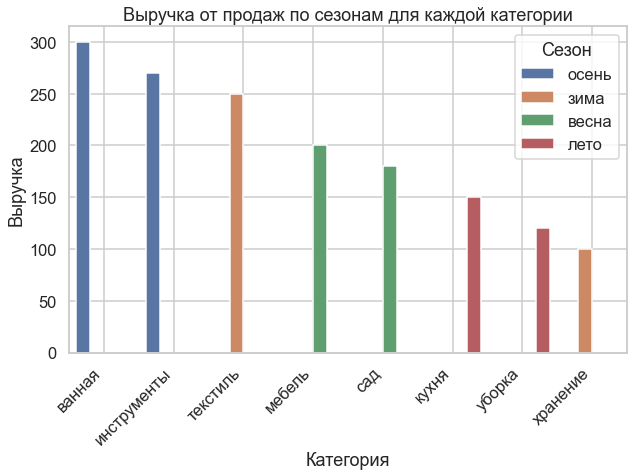

In [77]:
#Построим диаграммы продаж товаров по категориям и сезонам
data = {
    'month': [1, 4, 7, 10, 2, 5, 8, 11],
    'category': ['хранение', 'мебель', 'кухня', 'ванная', 'текстиль', 'сад', 'уборка', 'инструменты'],
    'revenue': [100, 200, 150, 300, 250, 180, 120, 270]
}
df_cat = pd.DataFrame(data)

# Добавление столбца 'season' с сезонами
df_cat ['season'] = df_cat['month'].apply(season)

# Группировка данных по сезонам и категориям, и подсчет суммы выручки
grouped_df = df_cat.groupby(['season', 'category'])['revenue'].sum().reset_index()

# Сортировка по выручке (убывающий порядок)
grouped_df = grouped_df.sort_values(by='revenue', ascending=False)

# Построение столбчатых диаграмм
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=grouped_df, x='category', y='revenue', hue='season', ax=ax)
plt.title('Выручка от продаж по сезонам для каждой категории')
plt.xlabel('Категория')
plt.ylabel('Выручка')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Сезон', loc='upper right')
plt.grid(True)
plt.show()

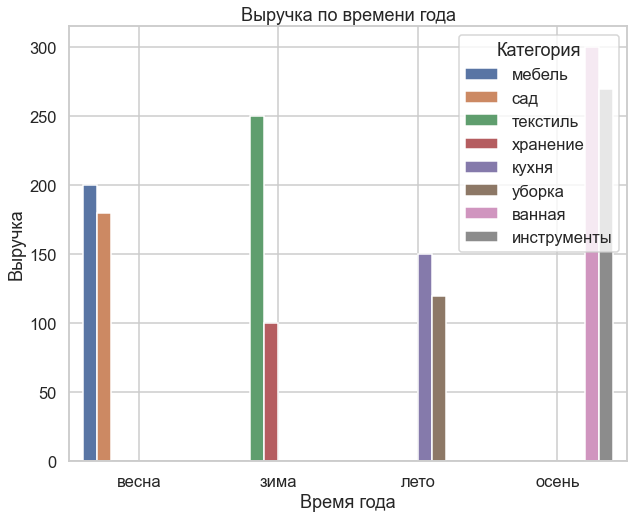

In [78]:
data = {
    'month': [1, 4, 7, 10, 2, 5, 8, 11],
    'category': ['хранение', 'мебель', 'кухня', 'ванная', 'текстиль', 'сад', 'уборка', 'инструменты'],
    'revenue': [100, 200, 150, 300, 250, 180, 120, 270]
}
df = pd.DataFrame(data)

# Добавление столбца 'season' с сезонами
df['season'] = df['month'].apply(season)

# Группировка данных по сезонам и категориям, и подсчет суммы выручки
grouped_df = df.groupby(['season', 'category'])['revenue'].sum().reset_index()

# Построение столбчатой диаграммы
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=grouped_df, x='season', y='revenue', hue='category', ax=ax)
plt.title('Выручка по времени года')
plt.xlabel('Время года')
plt.ylabel('Выручка')
plt.grid(True)
plt.legend(title='Категория', loc='upper right')
plt.show()

**Вывод**

По сезонам наибольшая выручка в категорях:

- Осенью - инструменты и ванная 
- Зимой - текстиль
- Весной - мебель и сад
- Летом - кухня и уборка

## Проверка статистических гипотез

### Узнаем есть ли в категории "хранение" статистически значимые различия продаж за октябрь-январь в 2018-2019 и 2019-2020 годах

**Гипотезы:**

- H0: В категории "хранение" статистически значимых различий в средних продажах за октябрь-январь в 2018-2019 и 2019-2020 годах нет.


- H1: В категории "хранение" статистически значимые различия в средних продажах за октябрь-январь в 2018-2019 и 2019-2020 годах есть.

In [79]:
storage_before = df_1.loc[(df_1['datetime'] < '2019-02-01') & (df_1['category'] == 'хранение')]
storage_after =  df_1.loc[(df_1['datetime'] >= '2019-10-01') & (df_1['category'] == 'хранение')]

print('Количество продаж за 10.2018-01.2019:', len(storage_before))
print('Количество продаж за 10.2019-01.2020:', len(storage_after))

list1 = storage_before['customer_id'].unique()
list2 = storage_after['customer_id'].unique()
ids = [x for x in list2 if x in list1]
len(ids)

Количество продаж за 10.2018-01.2019: 208
Количество продаж за 10.2019-01.2020: 149


7

In [80]:
storage_after = storage_after[~storage_after['customer_id'].isin(ids)]
len(storage_after)

142

In [81]:
storage_2019 = storage_before['revenue'].to_list()
storage_2020 = storage_after.sample(141)['revenue'].to_list()

alpha = 0.05

results = st.ttest_ind(storage_2019, storage_2020)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.5124783281616672
Не получилось отвергнуть нулевую гипотезу


**Вывод**

В категории "хранение" статистически значимые различия средних продаж за октябрь-январь в 2018-2019 и 2019-2020 годах есть.

### Узнаем различаются ли средняя цена товаров основного и дополнительного ассортимента

**Гипотезы:**

- H0: статистически значимых различий в средней цене товаров основного и дополнительного ассортиментов нет. 

- H1: статистически значимые различия в средней цене товаров основного и дополнительного ассортиментов есть.

In [82]:
main =  df_1.loc[df_1['assortment'] == 'основной']
addit = df_1.loc[df_1['assortment'] == 'дополнительный']
print(len(main))
print(len(addit))

2334
3196


In [83]:
mainList = main['price'].to_list()
additlList = addit['price'].to_list()

alpha = 0.05

# так как выборки разной длины, укажем "equal_var= False"
results = st.ttest_ind(mainList, additlList, equal_var= False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print() 
print('Средняя цена товаров основного ассортимента:', round(main['price'].mean(), 2))
print('Средняя цена товаров дополнительного ассортимента:', round(addit['price'].mean(), 2))

p-значение: 5.290326602021879e-170
Отвергаем нулевую гипотезу

Средняя цена товаров основного ассортимента: 1023.23
Средняя цена товаров дополнительного ассортимента: 180.11


**Вывод**

- В категории "хранение" статистически значимые различия средних продаж за октябрь-январь в 2018-2019 и 2019-2020 годах есть. 

- Статистически значимые различия в средней цене товаров основного и дополнительного ассортиментов есть.

## Общие выводы и рекомендации

По очищенным данным:

- В таблице 2404 уникальных покупателя совершивших 3471 заказ за 487 дней.
- Большинство покупателей совершило всего 1 заказ.
- Покупателей, сделавших 3 заказа мало.
- Среднее количество уникальных покупателей в день - 6 человек.
- Среднее количество уникальных покупателей в неделю - 46 человек.
- Среднее количество уникальных покупателей в месяц - 199 человек.
- Недельная аудитория - 14.6%
- Месячная аудитория - 3.37%
- За месяц интернет-магазин в среднеем имеет 183 клиента. Это небольшая цифра. Видно, что покупают нечасто.
- На графиках в феврале-марте 2019 виден рост активности покупателей. Затем падение активности с апреля до июля 2019 года. С июля снова 2019 видим небольшой рост. 
- Продаж больше всего в конце и начале года, а также на праздники 23.02. и 08.03.

**Заказы**

Большинство заказов совершаются в первой половине дня с 9 до 15. Пик приходится на 11 часов. Меньше всего клиенты заказываю ночью.

С воскресенья виден рост заказов. Пик приходится на вторник, с наибольшим количеством покупок. Затем снижение, и меньше всего продаж в субботу.

В апреле и феврале 2019, а также январе 2020 сделано больше всего заказов. Это коррелирует с активностью клиентов. То есть, количество сделавших заказ зависит от активности покупателей.


**Выручка**

Общая сумма выручки - 3 672 746.42 eд.

Cредняя выручка с покупателя - 664.15 eд.


День недели вторник в 13:00 дня самый продуктивный, приносит больше всего выручки. В течение всего периода 2018-2020 наблюдается негативная динамика суммарной выручки от продаж.

Общая сумма выручки в конце 2019 года сократилась почти в 1,5 раза, относительно прошлого года. Причиной могло послужить общее ухудшение экономической ситуации, сокращение объёма рынка.

Снижение доходов с продаж также видно по среднему чеку покупателя. В октябре 2018 года средний чек покупателя был 1377.92, а через год, в октябре 2019 года - 962.81 ед.

**Топ-5 товаров в каждой категории по количеству заказов за всё время**

- пеларгония розебудная red pandora
- сумка-тележка 2-х колесная gimi argo синяя
- таз пластмассовый со стиральной доской
- муляж яблоко оранжевый 85 см полиуретан
- чехол для костюма 60х110 см rozenbal
- коврик придверный хлопковый 60х140 см
- кувшин пластмассовый с крышкой "кумган" 20 л
- карниз для ванной комнаты виолет раздвижной
- стяжка оконная с болтом ст-55 цинк 1
- мыло ручной работы сувенир подарок на 8 марта классика

**Топ-5 самых прибыльных товара за весь период:**

- простынь вафельная 200х180 см wellness
- урна уличная "гео" hobbyka/хоббика
- мусорный контейнер hailo bigbin swing 45
- одеяло wellness t142 белое темостеганое 140х205 см
- сушилка уличная leifheit 85210 linomatic

**Топ-5 самых продаваемых товаров за весь период:**

- эхинокактус грузони d-5 см
- коврик придверный attribute nature кокосовый 60x40 см amc015
- простынь вафельная 200х180 см wellness rw180-01 100% хлопок
- цветок искусственный гвоздика пластиковая одиночная в ассортименте 50 см
- муляж яблоко зеленый 9 см полиуретан

По матрице, наблюдаем корреляцию переменных. Есть небольшая взаимозависимость выручки с ценой товара corr = 0,75, то есть чем выше цена товара, тем больше выручка. Также, положительно коррелируют с выручкой количество заказов и количество товара.

**По результатам анализа товарного ассортимента:**

По сумме выручки, самая прибыльная категория — это «хранение», затем идёт категория «сад». Наименее прибыльная категория «гигиена».

По количеству заказов, самые продаваемые товары категории «сад», затем идет категория «хранение», что подтверждает основной товарный ассортимент — это категория «сад», а остальные — дополнительные.

По среднему чеку, как показателю эффективности продаж, категория «сад» дает самую малую выручку. Чтобы улучшить данный показатель предложим ввести кросс-продажи, предлагать клиентам магазина сопутствующий товар со скидкой. Можно работать с ассортиментом и его сортировкой, предлагая позиции дороже среднего чека. Проводить акции и давать спецпредложения.

**Основной доход интернет-магазина от категорий «хранение», «текстиль», «инструменты» и «уборка»**

**Топ товаров в каждой категории по количеству заказов за всё время:**

- В категории «cад» - пеларгония розебудная red pandora
- В категории «хранение» - сумка-тележка 2-х колесная gimi argo синяя
- В категории «уборка» - таз пластмассовый со стиральной доской
- В категории «декор» -  муляж яблоко оранжевый 85 см полиуретан
- В категории «текстиль» -  чехол для костюма 60х110 см rozenbal
- В категории «ванная» - коврик придверный хлопковый 60х140 см
- В категории «кухня» -  кувшин пластмассовый с крышкой "кумган" 20 л
- В категории «мебель» -  карниз для ванной комнаты виолет раздвижной
- В категории «инструменты» -  стяжка оконная с болтом ст-55 цинк 1
- В категории «гигиена» -  мыло ручной работы сувенир подарок на 8 марта классика

**Топ самых прибыльных товаров в каждой категории за всё время:**

- В категории «текстиль» -  простынь вафельная 200х180 см wellness
- В категории «хранение» -  сумка-тележка 2-х колесная gimi
- В категории «уборка» -  сушилка meliconi stendy junior
- В категории «ванная» самый прибыльный товар: коврик придверный attribute nature кокосовый
- В категории «cад» -  сушилка уличная leifheit 85210 linomatic
- В категории «инструменты» -  стремянка colombo leonardo 2 ступени
- В категории «кухня» - модульная стеклянная банка
- В категории «гигиена» -  паста зубная для профилактики заболеваний десен kobayashi японский кипарис
- В категории «мебель» -  карниз для ванной комнаты виолет раздвижной
- В категории «декор» -  афеляндра скуарроса дания микс в кашпо с автополивом

**АВС-анализ показал, что:**

Основной доход интернет-магазина из категорий «хранение», «сад», «уборка» и «ванная».

**Львиную долю выручки приносят 2 вида товаров:**

- простынь вафельная 200х180 см wellness rw180-01 100% хлопок
- сумка-тележка 2-х колесная gimi argo синяя

**По результатам проверки гипотез:**

 - В категории "хранение" статистически значимые различия средних продаж за октябрь-январь в 2018-2019 и 2019-2020 годах есть. 

- Статистически значимые различия в средней цене товаров основного и дополнительного ассортиментов есть. 

**Рекомендации:**

1. Повысить средний чек в категории «сад», основном ассортименте товаров магазина. Для этого необходим кросс-селинг, предлагать клиентам приобрести сопутствующий товар со скидкой. Можно поработать с ассортиментом и его сортировкой, предлагать позиции дороже среднего чека. Проводить акции и давать индивидуальные спецпредложения.


2. Увеличить объёмы продаж. Поискать причину снижения доходов. Для этого необходимо посмотреть на факторы, которые влияют на продажи:

- бизнес-модель и бизнес-процессы; 
- руководство, персонал;
- каналы сбыта товара;
- сезонная динамика продаж; 
- товарный ассортимент;
- количество покупателей;
- конкурентный анализ;
- целевая модель продаж;
- общая динамика рынка.

3. В зависимости от сезона, создавать актуальные предложения внутри каждой товарной категории.


4. Сформировать у покупателей привычку заходить в интернет-магазин как можно чаще. Для чего поработать над дизайном главной страницы, удобством навигации, быстротой оформления покупки, оплаты и доставки товара.   

Ссылка на дашборд - https://clck.ru/35GX28

Ссылка на презентацию - https://clck.ru/35LSG6